# Enhancing Customer Retention in Banking: A Machine Learning Ensemble Approach

### Problem statement :

Bank XYZ has been observing a lot of customers closing their accounts or switching to competitor banks over the past couple of quarters. As such, this has caused a huge dent in the quarterly revenues and might drastically affect annual revenues for the ongoing financial year, causing stocks to plunge and market cap to reduce by X %. A team of business, product, engineering and data science folks have been put together to arrest this slide. 

__Objective__ : Can we build a model to predict, with a reasonable accuracy, the customers who are going to churn in the near future? Being able to accurately estimate when they are going to churn will be an added bonus

__Definition of churn__ : A customer having closed all their active accounts with the bank is said to have churned. Churn can be defined in other ways as well, based on the context of the problem. A customer not transacting for 6 months or 1 year can also be defined as to have churned, based on the business requirements 

__From a Business team/Product Manager's perspective :__  

(1) Business goal : Arrest slide in revenues or loss of active bank customers

(2) Identify data source : Transactional systems, event-based logs, Data warehouse (MySQL DBs, Redshift/AWS), Data Lakes, NoSQL DBs

(3) Audit for data quality : De-duplication of events/transactions, Complete or partial absence of data for chunks of time in between, Obscuring PII (personal identifiable information) data 

(4) Define business and data-related metrics : Tracking of these metrics over time, probably through some intuitive visualizations
    
    (i) Business metrics : Churn rate (month-on-month, weekly/quarterly), Trend of avg. number of products per customer, 
        %age of dormant customers, Other such descriptive metrics
    
    (ii) Data-related metrics : F1-score, Recall, Precision
         Recall = TP/(TP + FN) 
         Precision = TP/(TP + FP)
         F1-score = Harmonic mean of Recall and Precision
         where, TP = True Positive, FP = False Positive and FN = False Negative

(5) Prediction model output format : Since this is not going to be an online model, it doesn't require deployment. Instead, periodic (monthly/quarterly) model runs could be made and the list of customers, along with their propensity to churn shared with the business (Sales/Marketing) or Product team

(6) Action to be taken based on model's output/insights : Based on the output obtained from Data Science team as above, various business interventions can be made to save the customer from getting churned. Customer-centric bank offers, getting in touch with customers to address grievances etc. Here, also Data Science team can help with basic EDA to highlight different customer groups/segments and the appropriate intervention to be applied against them

### How to set the target/goal for the metrics?

* Data science-related metrics :
    - Recall : >70%
    - Precision : >70%
    - F1-score : >70%


* Business Metrics : Usually, it's top down. But a good practice is to consider it to make atleast half the impact of the data science metric. For e.g., If we take Recall target as __70%__ which means correctly identifying 70% of customers who's going to churn in the near future, we can expect that due to business intervention (offers, getting in touch with customers etc.), 50% of the customers can be saved from being churned, which means atleast a __35%__ improvement in Churn Rate

### Coding Part

In [1]:
"""!pip install ipython==7.22.0
!pip install joblib==1.0.1
!pip install lightgbm==3.3.1
!pip install matplotlib==3.3.4
!pip install numpy==1.20.1
!pip install pandas==1.3.5
!pip install scikit_learn==0.24.1
!pip install seaborn==0.11.1
!pip install shap==0.40.0
!pip install xgboost==1.5.1"""

'!pip install ipython==7.22.0\n!pip install joblib==1.0.1\n!pip install lightgbm==3.3.1\n!pip install matplotlib==3.3.4\n!pip install numpy==1.20.1\n!pip install pandas==1.3.5\n!pip install scikit_learn==0.24.1\n!pip install seaborn==0.11.1\n!pip install shap==0.40.0\n!pip install xgboost==1.5.1'

In [2]:
%matplotlib inline

In [3]:
## Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [5]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
## Reading the dataset
# This might be present in S3, or obtained through a query on a database
df = pd.read_csv("Churn_Modelling.csv")

In [7]:
df.shape

(10000, 14)

In [8]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
RowNumber,1,2,3,4,5,6,7,8,9,10
CustomerId,15634602,15647311,15619304,15701354,15737888,15574012,15592531,15656148,15792365,15592389
Surname,Hargrave,Hill,Onio,Boni,Mitchell,Chu,Bartlett,Obinna,He,H?
CreditScore,619,608,502,699,850,645,822,376,501,684
Geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France
Gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male
Age,42,41,42,39,43,44,50,29,44,27
Tenure,2,1,8,1,2,8,7,4,4,2
Balance,0.0,83807.86,159660.8,0.0,125510.82,113755.78,0.0,115046.74,142051.07,134603.88
NumOfProducts,1,1,3,2,1,2,2,4,2,1


### Basic EDA

In [9]:
df.describe() # Describe all numerical columns
df.describe(include = ['O']) # Describe all non-numerical/categorical columns

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [10]:
## Checking number of unique customers in the dataset
df.shape[0], df.CustomerId.nunique()

(10000, 10000)

In [11]:
df_t = df.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

In [12]:
df_t.head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


In [13]:
df.Geography.value_counts(normalize=True)

Geography
France     0.5014
Germany    0.2509
Spain      0.2477
Name: proportion, dtype: float64

#### Conclusion

 - Discard row number
 - Discard CustomerID as well, since it doesn't convey any extra info. Each row pertains to a unique customer
 - Based on the above, columns/features can be segregated into non-essential, numerical, categorical and target variables
 
In general, CustomerID is a very useful feature on the basis of which we can calculate a lot of user-centric features. Here, the dataset is not sufficient to calculate any extra customer features

In [14]:
## Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

Among these, Tenure and NumOfProducts are ordinal variables. HasCrCard and IsActiveMember are actually binary categorical variables.

In [15]:
## Separating out target variable and removing the non-essential columns
y = df[target_var].values
df.drop(cols_to_remove, axis=1, inplace=True)

### Questioning the data :

 - No date/time column. A lot of useful features can be built using date/time columns
 - When was the data snapshot taken? There are certain customer features like : Balance, Tenure, NumOfProducts, EstimatedSalary, which will have different values across time
 - Are all these values/features pertaining to the same single date or spread across multiple dates?
 - How frequently are customer features updated?
 - Will it be possible to have the values of these features over a period of time as opposed to a single, snapshot date?
 - Some customers who have exited still have balance in their account, or a non-zero NumOfProducts. Does this mean they have churned only from a specific product and not the entire bank, or are these snapshots of just before they churned?
 - Some features like, number and kind of transactions, can help us estimate the degree of activity of the customer, instead of trusting the binary variable IsActiveMember
 - Customer transaction patterns can also help us ascertain whether the customer has actually churned or not. For example, a customer might transact daily/weekly vs a customer who transacts annuallly
 
 Here, the objective is to understand the data and distill the problem statement and the stated goal further. In the process, if more data/context can be obtained, that adds to the end result of the model performance

### Separating out train-test-valid sets

Since this is the only data available to us, we keep aside a holdout/test set to evaluate our model at the very end in order to estimate our chosen model's performance on unseen data / new data.

A validation set is also created which we'll use in our baseline models to evaluate and tune our models

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
## Keeping aside a test/holdout set
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y.ravel(), test_size = 0.1, random_state = 42)

## Splitting into train and validation set
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size = 0.12, random_state = 42)

In [18]:
df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

### Univariate plots of numerical variables in training set

<Axes: ylabel='CreditScore'>

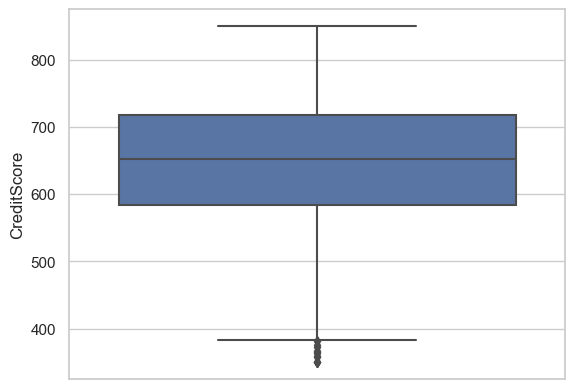

In [19]:
## CreditScore
sns.set(style="whitegrid")
sns.boxplot(y = df_train['CreditScore'])

<Axes: ylabel='Age'>

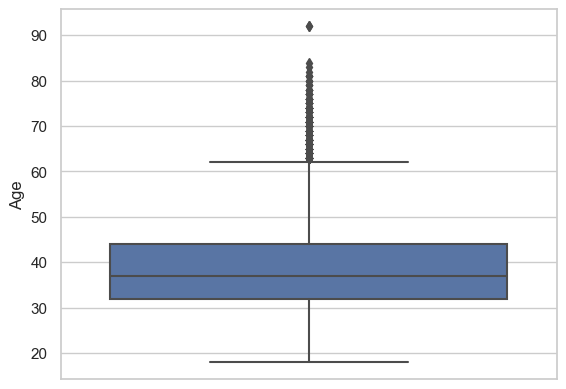

In [20]:
## Age
sns.boxplot(y = df_train['Age'])

<Axes: ylabel='Tenure'>

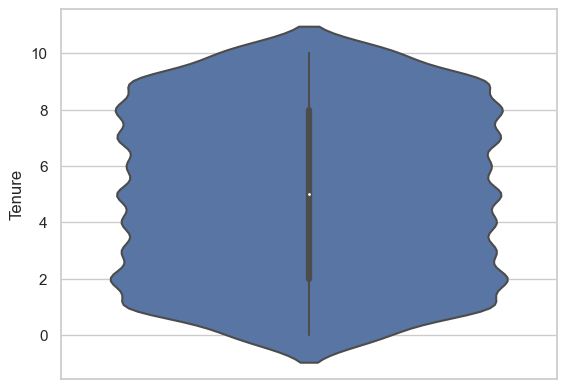

In [21]:
## Tenure
sns.violinplot(y = df_train.Tenure)

<Axes: ylabel='Balance'>

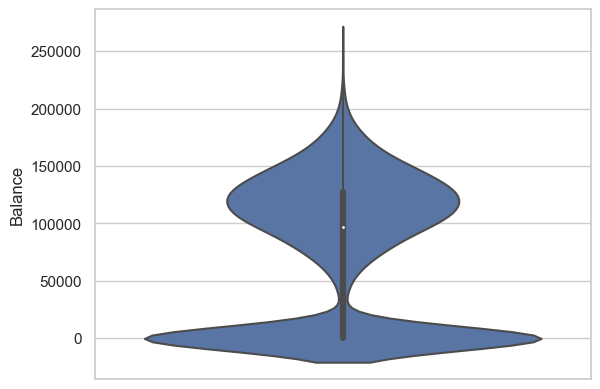

In [22]:
## Balance
sns.violinplot(y = df_train['Balance'])

<Axes: xlabel='NumOfProducts'>

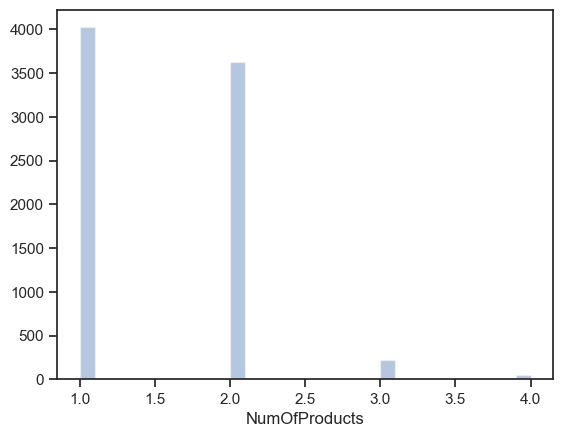

In [23]:
## NumOfProducts
sns.set(style = 'ticks')
sns.distplot(df_train.NumOfProducts, hist=True, kde=False)

<Axes: xlabel='EstimatedSalary', ylabel='Density'>

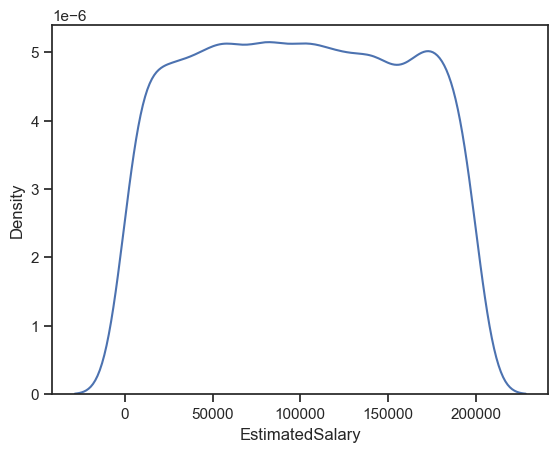

In [24]:
## EstimatedSalary
sns.kdeplot(df_train.EstimatedSalary)

 - From the univariate plots, we get an indication that _EstimatedSalary_ , being uniformly distributed, might not turn out to be an important predictor 
 - Similarly, for _NumOfProducts_ , there are predominantly only two values (1 and 2). Hence, its chances of being a strong predictor is also very unlikely
 - On the other hand, _Balance_ has a multi-modal distribution. We'll see a little later if that helps in separation of the two target classes

### Missing values and outlier treatment

#### Outliers

* Can be observed from univariate plots of different features

* Outliers can either be logically improbable (as per the feature definition) or just an extreme value as compared to the feature distribution

* As part of outlier treatment, the particular row containing the outlier can be removed from the training set, provided they do not form a significant chunk of the dataset (< 0.5-1%)

* In cases where the value of outlier is logically faulty, e.g. negative Age or CreditScore > 900, the particular record can be replaced with mean of the feature or the nearest among min/max logical value of the feature 

Outliers in numerical features can be of a very high/low value, lying in the top 1% or bottom 1% of the distribution or values which are not possible as per the feature definition.

Outliers in categorical features are usually levels with a very low frequency/no. of samples as compared to other categorical levels.

__No outliers observed in any feature of this dataset__

##### Is outlier treatment always required ?

No, Not all ML algorithms are sensitive to outliers. Algorithms like linear/logistic regression are sensitive to outliers.

Tree algorithms, kNN, clustering algorithms etc. are in general, robust to outliers

Outliers affect metrics such as mean, std. deviation

#### Missing values

In [25]:
## No missing values!
df_train.isnull().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing values present in this dataset. Can also be observed from df.describe() commands. However, most real-world datasets might have missing values. A couple of things which can be done in such cases :
 - If the column/feature has too many missing values, it can be dropped as it might not add much relevance to the data
 - If there a few missing values, the column/feature can be imputed with its summary statistics (mean/median/mode) and/or numbers like 0, -1 etc. which add value depending on the data and context. For example, say, BalanceInAccount.

In [26]:
## Making all changes in a temporary dataframe
df_missing = df_train.copy()

In [27]:
## Modify few records to add missing values/outliers

# Introducing 10% nulls in Age
na_idx = df_missing.sample(frac = 0.1).index
df_missing.loc[na_idx, 'Age'] = np.NaN

# Introducing 30% nulls in Geography
na_idx = df_missing.sample(frac = 0.3).index
df_missing.loc[na_idx, 'Geography'] = np.NaN

# Introducing 5% nulls in HasCrCard
na_idx = df_missing.sample(frac = 0.05).index
df_missing.loc[na_idx, 'HasCrCard'] = np.NaN

In [28]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.00
CreditScore        0.00
Geography          0.30
Gender             0.00
Age                0.10
Tenure             0.00
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.05
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

In [29]:
## Calculating mean statistics
age_mean = df_missing.Age.mean()

In [30]:
age_mean

38.87317620650954

In [31]:
# Filling nulls in Age by mean value (numeric column)

#df_missing.Age.fillna(age_mean, inplace=True)

df_missing['Age'] = df_missing.Age.apply(lambda x: int(np.random.normal(age_mean,3)) if np.isnan(x) else x)

<Axes: xlabel='Age', ylabel='Density'>

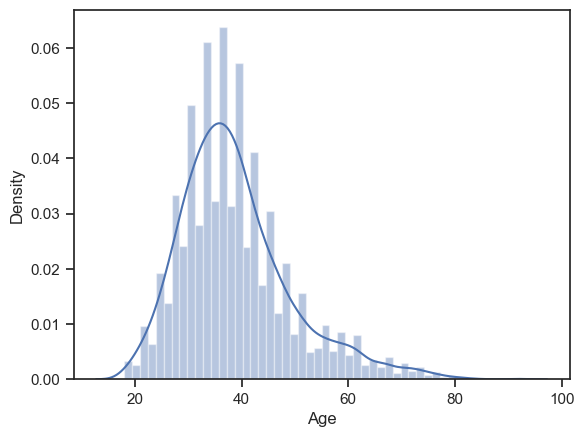

In [32]:
## Distribution of "Age" feature before data imputation
sns.distplot(df_train.Age)

<Axes: xlabel='Age', ylabel='Density'>

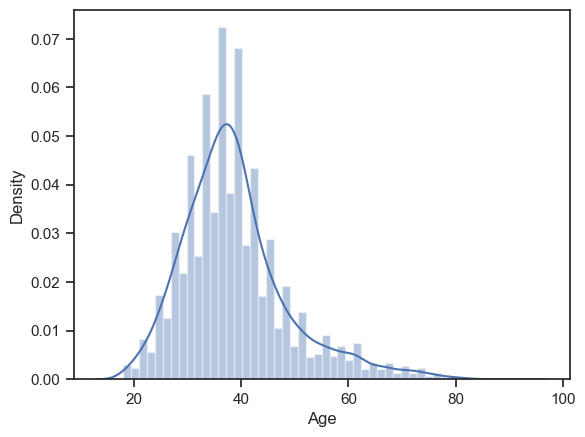

In [33]:
## Distribution of "Age" feature after data imputation
sns.distplot(df_missing.Age)

In [34]:
# Filling nulls in Geography (categorical feature with a high %age of missing values)
geog_fill_value = 'UNK'
df_missing.Geography.fillna(geog_fill_value, inplace=True)

# Filling nulls in HasCrCard (boolean feature) - 0 for few nulls, -1 for lots of nulls
df_missing.HasCrCard.fillna(0, inplace=True)

In [35]:
df_missing.Geography.value_counts(normalize=True)

Geography
France     0.354419
UNK        0.300000
Spain      0.174495
Germany    0.171086
Name: proportion, dtype: float64

In [36]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Categorical variable encoding

As a rule of thumb, we can consider using :

 1. Label Encoding ---> Binary categorical variables and Ordinal variables
 2. One-Hot Encoding ---> Non-ordinal categorical variables with low to mid cardinality (< 5-10 levels)
 3. Target encoding ---> Categorical variables with > 10 levels

* HasCrCard and IsActiveMember are already label encoded
* For Gender, a simple Label encoding should be fine.
* For Geography, since there are 3 levels, OneHotEncoding should do the trick
* For Surname, we'll try Target/Frequency Encoding

#### Label Encoding for binary variables

In [37]:
## The non-sklearn method
df_train['Gender_cat'] = df_train.Gender.astype('category').cat.codes

In [38]:
df_train.sample(10)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_cat
3009,Mai,551,France,Male,31,1,0.00,2,1,1,185105.44,0,1
6836,Donnelly,715,Spain,Male,42,6,0.00,2,1,1,128745.69,0,1
6022,Chin,694,Spain,Female,35,7,0.00,1,1,0,133570.43,1,0
4129,Macfarlan,618,France,Male,48,7,0.00,1,1,0,13921.82,1,1
1907,O'Toole,620,France,Female,67,3,0.00,2,1,1,43486.73,0,0
7495,Sutherland,557,France,Female,27,2,0.00,2,0,1,4497.55,0,0
2739,Younger,625,France,Male,45,7,137555.44,1,0,0,124607.70,0,1
7786,Drury,586,Spain,Female,33,10,66948.67,2,1,1,140759.03,0,0
629,Rahman,799,Spain,Female,28,3,142253.65,1,1,0,45042.56,0,0
5865,Lynch,663,France,Male,39,4,0.00,1,1,0,76884.05,0,1


In [39]:
df_train.drop('Gender_cat', axis=1, inplace = True)

In [40]:
## The sklearn method
from sklearn.preprocessing import LabelEncoder

In [41]:
le = LabelEncoder()

We fit only on train dataset as that's the only data we'll assume we have. We'll treat validation and test sets as unseen data. Hence, they can't be used for fitting the encoders.

In [42]:
## Label encoding of Gender variable
df_train['Gender'] = le.fit_transform(df_train['Gender'])

In [43]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'Female': 0, 'Male': 1}

In [44]:
## What if Gender column has new values in test or val set?
le.transform([['Male']])
#le.transform([['ABC']])

array([1])

In [45]:
pd.Series(['ABC']).map(le_name_mapping)

0   NaN
dtype: float64

In [46]:
## Encoding Gender feature for validation and test set
df_val['Gender'] = df_val.Gender.map(le_name_mapping)
df_test['Gender'] = df_test.Gender.map(le_name_mapping)

## Filling missing/NaN values created due to new categorical levels
df_val['Gender'].fillna(-1, inplace=True)
df_test['Gender'].fillna(-1, inplace=True)

In [47]:
df_train.Gender.unique(), df_val.Gender.unique(), df_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

#### One-Hot encoding for categorical variables with multiple levels

In [48]:
## The non-sklearn method
t = pd.get_dummies(df_train, prefix_sep = "_", columns = ['Geography'])
t.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
4562,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,False,True,False
6498,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,True,False,False
6072,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,True,False,False
5813,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,True,False,False
7407,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,True,False,False


In [49]:
### Dropping dummy column
t.drop(['Geography_France'], axis=1, inplace=True)
t.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
4562,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,True,False
6498,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,False,False
6072,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,False,False
5813,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,False,False
7407,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,False,False


In [50]:
## The sklearn method
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [51]:
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

In [52]:
enc_train = le_ohe.fit_transform(df_train.Geography).reshape(df_train.shape[0],1)
enc_train.shape
np.unique(enc_train)

(7920, 1)

array([0, 1, 2])

In [53]:
ohe_train = ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [54]:
le_ohe_name_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_name_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [55]:
## Encoding Geography feature for validation and test set
enc_val = df_val.Geography.map(le_ohe_name_mapping).ravel().reshape(-1,1)
enc_test = df_test.Geography.map(le_ohe_name_mapping).ravel().reshape(-1,1)

## Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999

In [56]:
np.unique(enc_val)
np.unique(enc_test)

array([0, 1, 2])

array([0, 1, 2])

In [57]:
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

In [58]:
### Show what happens when a new value is inputted into the OHE 
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

#### Adding the one-hot encoded columns to the dataframe and removing the original feature

In [59]:
cols = ['country_' + str(x) for x in le_ohe_name_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [60]:
## Adding to the respective dataframes
df_train = pd.concat([df_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
df_val = pd.concat([df_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
df_test = pd.concat([df_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)

In [61]:
print("Training set")
df_train.head()
print("\n\nValidation set")
df_val.head()
print("\n\nTest set")
df_test.head()

Training set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,Germany,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,France,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,France,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,France,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,France,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,France,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,France,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,France,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,France,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,Spain,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


In [62]:
## Drop the Geography column
df_train.drop(['Geography'], axis = 1, inplace=True)
df_val.drop(['Geography'], axis = 1, inplace=True)
df_test.drop(['Geography'], axis = 1, inplace=True)

#### Target encoding

Target encoding is generally useful when dealing with categorical variables of high cardinality (high number of levels).

Here, we'll encode the column 'Surname' (which has 2932 different values!) with the mean of target variable for that level

In [63]:
df_train.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0


In [64]:
means = df_train.groupby(['Surname']).Exited.mean()
means.head()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

In [65]:
global_mean = y_train.mean()
global_mean

0.20303030303030303

In [66]:
## Creating new encoded features for surname - Target (mean) encoding
df_train['Surname_mean_churn'] = df_train.Surname.map(means)
df_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

But, the problem with Target encoding is that it might cause data leakage, as we are considering feedback from the target variable while computing any summary statistic.

A solution is to use a modified version : Leave-one-out Target encoding.

In this, for a particular data point or row, the mean of the target is calculated by considering all rows in the same categorical level except itself. This mitigates data leakage and overfitting to some extent.

Mean for a category, __m<sub>c</sub> = S<sub>c</sub> / n<sub>c</sub>__    .....   (1)

What we need to find is the mean excluding a single sample. This can be expressed as : __m<sub>i</sub> = (S<sub>c</sub> - t<sub>i</sub>) / (n<sub>c</sub> - 1)__     .....   (2)

Using (1) and (2), we can get : __m<sub>i</sub> = (n<sub>c</sub>m<sub>c</sub> - t<sub>i</sub>) / (n<sub>c</sub> - 1)__

Here, _S<sub>c</sub>_ = Sum of target variable for category c

_n<sub>c</sub>_ = Number of rows in category c   

_t<sub>i</sub>_ = Target value of the row whose encoding is being calculated


In [67]:
## Calculate frequency of each category
freqs = df_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

In [68]:
## Create frequency encoding - Number of instances of each category in the data
df_train['Surname_freq'] = df_train.Surname.map(freqs)
df_train['Surname_freq'].fillna(0, inplace=True)

In [69]:
## Create Leave-one-out target encoding for Surname
df_train['Surname_enc'] = ((df_train.Surname_freq * df_train.Surname_mean_churn) - df_train.Exited)/(df_train.Surname_freq - 1)
df_train.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000
5,Miller,562,1,30,3,111099.79,2,0,0,140650.19,0,1.0,0.0,0.0,0.285714,14,0.307692
6,Padovesi,635,1,43,5,78992.75,2,0,0,153265.31,0,0.0,1.0,0.0,0.200000,10,0.222222
7,Edments,705,1,33,7,68423.89,1,1,1,64872.55,0,0.0,0.0,1.0,0.000000,1,NaN
8,Chan,694,1,42,8,133767.19,1,1,0,36405.21,0,1.0,0.0,0.0,0.000000,3,0.000000
9,Matthews,711,1,26,9,128793.63,1,1,0,19262.05,0,0.0,1.0,0.0,0.000000,4,0.000000


In [70]:
## Fill NaNs occuring due to category frequency being 1 or less
df_train['Surname_enc'].fillna((((df_train.shape[0] * global_mean) - df_train.Exited) / (df_train.shape[0] - 1)), inplace=True)
df_train.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000
5,Miller,562,1,30,3,111099.79,2,0,0,140650.19,0,1.0,0.0,0.0,0.285714,14,0.307692
6,Padovesi,635,1,43,5,78992.75,2,0,0,153265.31,0,0.0,1.0,0.0,0.200000,10,0.222222
7,Edments,705,1,33,7,68423.89,1,1,1,64872.55,0,0.0,0.0,1.0,0.000000,1,0.203056
8,Chan,694,1,42,8,133767.19,1,1,0,36405.21,0,1.0,0.0,0.0,0.000000,3,0.000000
9,Matthews,711,1,26,9,128793.63,1,1,0,19262.05,0,0.0,1.0,0.0,0.000000,4,0.000000


On validation and test set, we'll apply the normal Target encoding mapping as obtained from the training set

In [71]:
## Replacing by category means and new category levels by global mean
df_val['Surname_enc'] = df_val.Surname.map(means)
df_val['Surname_enc'].fillna(global_mean, inplace=True)

df_test['Surname_enc'] = df_test.Surname.map(means)
df_test['Surname_enc'].fillna(global_mean, inplace=True)

In [72]:
## Show that using LOO Target encoding decorrelates features
df_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


In [73]:
### Deleting the 'Surname' and other redundant column across the three datasets
df_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
df_train.drop(['Surname_freq'], axis=1, inplace=True)
df_train.drop(['Surname'], axis=1, inplace=True)
df_val.drop(['Surname'], axis=1, inplace=True)
df_test.drop(['Surname'], axis=1, inplace=True)

In [74]:
df_train.head()
df_val.head()
df_test.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,757,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0,0.111111
1,552,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0,0.200000
2,619,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0,0.500000
3,633,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0,0.000000
4,698,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0,1.000000


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,596,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0,0.083333
1,623,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0,0.203030
2,601,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0,0.333333
3,506,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0,0.153846
4,560,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0,0.230769


#### _Summarize_ : How to handle unknown categorical levels/values in unseen data in production?

 - Use LabelEncoding, OneHotEncoding on training set and then save the mapping and apply on the test set. For missing values, use 0, -1 etc.
 
 - Target/Frequency encoding : Create a mapping between each level and a statistical measure (mean, median, sum etc.) of the target from the training dataset. For the new categorical levels, impute the missing values suitably (can be 0, -1, or mean/mode/median)
 
 - Leave-one-out or Cross fold Target encoding avoid data leakage and help in generalization of the model

### Bivariate analysis

In [75]:
## Check linear correlation (rho) between individual features and the target variable
corr = df_train.corr()
corr

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
CreditScore,1.000000,0.000354,0.002099,0.005994,-0.001507,0.014110,-0.011868,0.035057,0.000358,-0.028117,-0.009481,0.003393,0.007561,-0.000739
Gender,0.000354,1.000000,-0.024446,0.010749,0.009380,-0.026795,0.007550,0.028094,-0.011007,-0.102331,0.000823,-0.018412,0.017361,0.008002
Age,0.002099,-0.024446,1.000000,-0.011384,0.027721,-0.033305,-0.019633,0.093573,-0.006827,0.288221,-0.038881,0.048764,-0.003648,-0.010844
Tenure,0.005994,0.010749,-0.011384,1.000000,-0.013081,0.018231,0.026148,-0.021263,0.010145,-0.010660,0.000021,-0.003131,0.003090,-0.006753
Balance,-0.001507,0.009380,0.027721,-0.013081,1.000000,-0.304318,-0.021464,-0.008085,0.027247,0.113377,-0.231770,0.405616,-0.136044,0.006925
NumOfProducts,0.014110,-0.026795,-0.033305,0.018231,-0.304318,1.000000,0.007202,0.014809,0.009769,-0.039200,0.002991,-0.015926,0.012388,-0.002020
HasCrCard,-0.011868,0.007550,-0.019633,0.026148,-0.021464,0.007202,1.000000,-0.006526,-0.008413,-0.013659,0.005881,0.008197,-0.014934,-0.000551
IsActiveMember,0.035057,0.028094,0.093573,-0.021263,-0.008085,0.014809,-0.006526,1.000000,-0.016446,-0.152477,0.002126,-0.020570,0.018003,0.004902
EstimatedSalary,0.000358,-0.011007,-0.006827,0.010145,0.027247,0.009769,-0.008413,-0.016446,1.000000,0.015881,-0.004512,0.010583,-0.005320,-0.009899
Exited,-0.028117,-0.102331,0.288221,-0.010660,0.113377,-0.039200,-0.013659,-0.152477,0.015881,1.000000,-0.106006,0.173492,-0.050264,-0.026440


<Axes: >

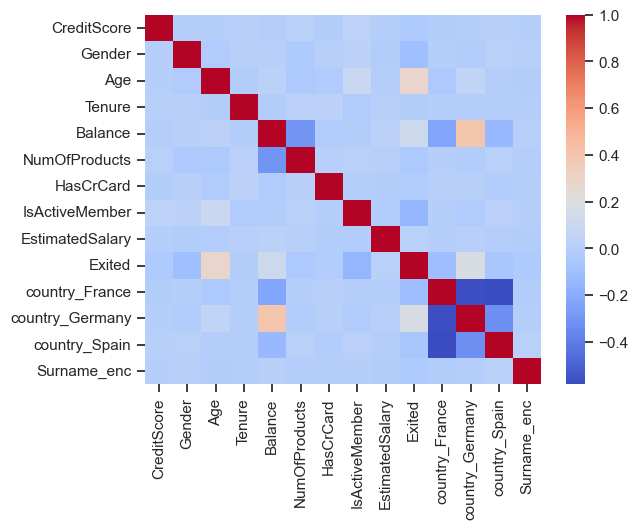

In [76]:
sns.heatmap(corr, cmap = 'coolwarm')

None of the features are highly correlated with the target variable. But some of them have slight linear associations with the target variable.

* Continuous features - Age, Balance 

* Categorical variables - Gender, IsActiveMember, country_Germany, country_France

#### Individual features versus their distibution across target variable values

<Axes: xlabel='Exited', ylabel='Age'>

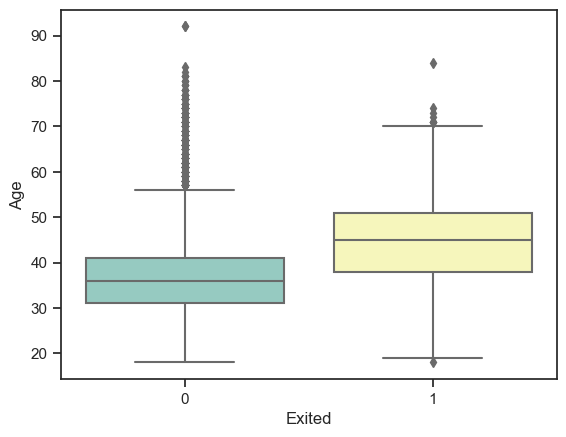

In [77]:
sns.boxplot(x = "Exited", y = "Age", data = df_train, palette="Set3")

<Axes: xlabel='Exited', ylabel='Balance'>

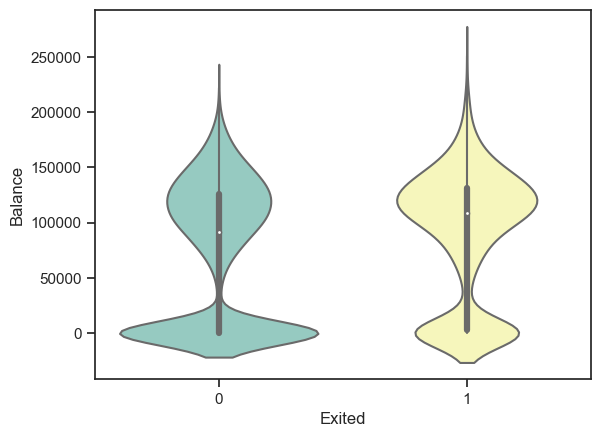

In [78]:
sns.violinplot(x = "Exited", y = "Balance", data = df_train, palette="Set3")

In [79]:
# Check association of categorical features with target variable
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    df_train.groupby([col]).Exited.mean()

Gender
0    0.248191
1    0.165511
Name: Exited, dtype: float64

IsActiveMember
0    0.266285
1    0.143557
Name: Exited, dtype: float64

country_Germany
0.0    0.163091
1.0    0.324974
Name: Exited, dtype: float64

country_France
0.0    0.245877
1.0    0.160593
Name: Exited, dtype: float64

In [80]:
col = 'NumOfProducts'
df_train.groupby([col]).Exited.mean()
df_train[col].value_counts()

NumOfProducts
1    0.273428
2    0.076881
3    0.825112
4    1.000000
Name: Exited, dtype: float64

NumOfProducts
1    4023
2    3629
3     223
4      45
Name: count, dtype: int64

### Some basic feature engineering

In [81]:
df_train.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc'],
      dtype='object')

Creating some new features based on simple interactions between the existing features.

* Balance/NumOfProducts
* Balance/EstimatedSalary
* Tenure/Age
* Age * Surname_enc

In [82]:
eps = 1e-6

df_train['bal_per_product'] = df_train.Balance/(df_train.NumOfProducts + eps)
df_train['bal_by_est_salary'] = df_train.Balance/(df_train.EstimatedSalary + eps)
df_train['tenure_age_ratio'] = df_train.Tenure/(df_train.Age + eps)
df_train['age_surname_mean_churn'] = np.sqrt(df_train.Age) * df_train.Surname_enc

In [83]:
df_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,58932.395534,4.267519,0.027778,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,125167.614832,0.628653,0.185185,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.200000,1.490712
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000,0.000000,0.000000,0.166667,1.643168
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000,0.000000,0.000000,0.181818,2.345208


In [84]:
new_cols = ['bal_per_product','bal_by_est_salary','tenure_age_ratio','age_surname_mean_churn']

In [85]:
## Ensuring that the new column doesn't have any missing values
df_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

<Axes: >

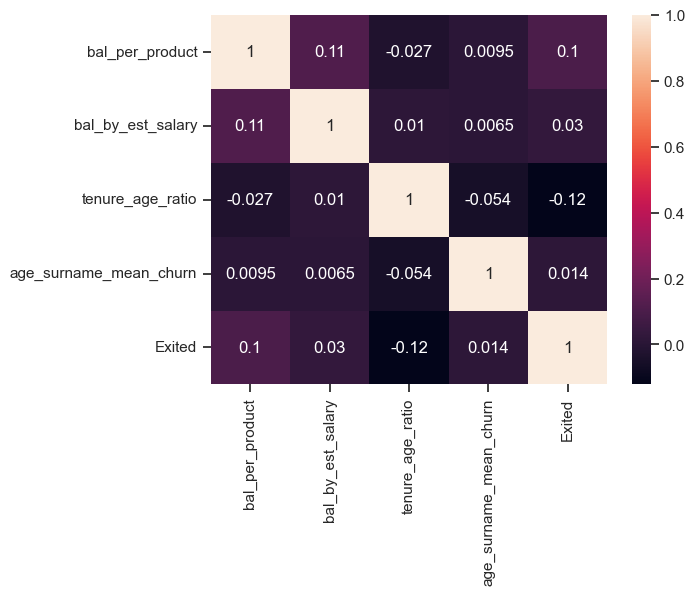

In [86]:
## Linear association of new columns with target variables to judge importance
sns.heatmap(df_train[new_cols + ['Exited']].corr(), annot=True)

Out of the new features, ones with slight linear association/correlation are : bal_per_product and tenure_age_ratio

In [87]:
## Creating new interaction feature terms for validation set
eps = 1e-6

df_val['bal_per_product'] = df_val.Balance/(df_val.NumOfProducts + eps)
df_val['bal_by_est_salary'] = df_val.Balance/(df_val.EstimatedSalary + eps)
df_val['tenure_age_ratio'] = df_val.Tenure/(df_val.Age + eps)
df_val['age_surname_mean_churn'] = np.sqrt(df_val.Age) * df_val.Surname_enc

In [88]:
## Creating new interaction feature terms for test set
eps = 1e-6

df_test['bal_per_product'] = df_test.Balance/(df_test.NumOfProducts + eps)
df_test['bal_by_est_salary'] = df_test.Balance/(df_test.EstimatedSalary + eps)
df_test['tenure_age_ratio'] = df_test.Tenure/(df_test.Age + eps)
df_test['age_surname_mean_churn'] = np.sqrt(df_test.Age) * df_test.Surname_enc

### Feature scaling and normalization

Different methods :

1. Feature transformations - Using log, log10, sqrt, pow
2. MinMaxScaler - Brings all feature values between 0 and 1
3. StandardScaler - Mean normalization. Feature values are an estimate of their z-score


* Why is scaling and normalization required ?


* How do we normalize unseen data?

#### Feature transformations

<Axes: xlabel='EstimatedSalary', ylabel='Density'>

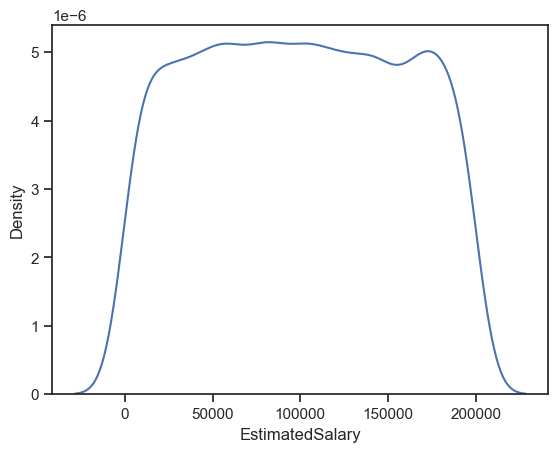

In [89]:
### Demo-ing feature transformations
sns.distplot(df_train.EstimatedSalary, hist=False)

<Axes: xlabel='EstimatedSalary', ylabel='Density'>

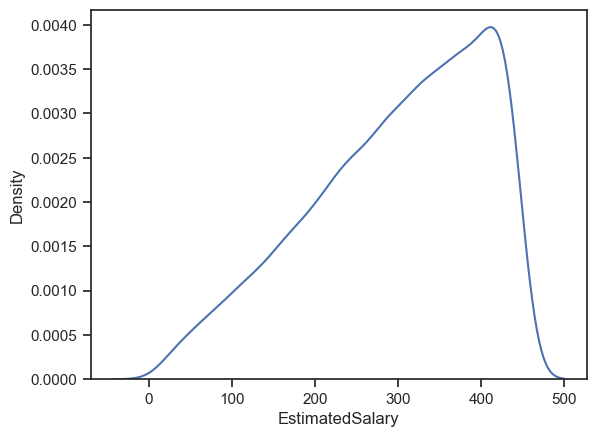

In [90]:
sns.distplot(np.sqrt(df_train.EstimatedSalary), hist=False)
#sns.distplot(np.log10(1+df_train.EstimatedSalary), hist=False)

#### StandardScaler

In [91]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [92]:
df_train.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

Scaling only continuous variables

In [93]:
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']

In [94]:
## Scaling only continuous columns
cols_to_scale = cont_vars

In [95]:
sc_X_train = sc.fit_transform(df_train[cols_to_scale])

In [96]:
## Converting from array to dataframe and naming the respective features/columns
sc_X_train = pd.DataFrame(data = sc_X_train, columns = cols_to_scale)
sc_X_train.shape
sc_X_train.head()

(7920, 11)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062389,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104840,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100925,-0.155854,0.690966,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100925,-0.155854,0.318773,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100925,-0.155854,0.487952,0.912973


In [97]:
## Mapping learnt on the continuous features
sc_map = {'mean':sc.mean_, 'std':np.sqrt(sc.var_)}
sc_map

{'mean': array([6.50542424e+02, 3.88912879e+01, 5.01376263e+00, 7.60258447e+04,
        1.53156566e+00, 9.96616540e+04, 2.04321788e-01, 6.24727199e+04,
        2.64665647e+00, 1.38117689e-01, 1.26136416e+00]),
 'std': array([9.64231806e+01, 1.05374237e+01, 2.88940724e+00, 6.23738902e+04,
        5.82587032e-01, 5.74167173e+04, 1.89325378e-01, 5.67456646e+04,
        1.69816787e+01, 8.95590667e-02, 1.18715858e+00])}

In [98]:
## Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(df_val[cols_to_scale])
sc_X_test = sc.transform(df_test[cols_to_scale])

In [99]:
## Converting val and test arrays to dataframes for re-usability
sc_X_val = pd.DataFrame(data = sc_X_val, columns = cols_to_scale)
sc_X_test = pd.DataFrame(data = sc_X_test, columns = cols_to_scale)

Feature scaling is important for algorithms like Logistic Regression and SVM. Not necessary for Tree-based models

### Feature selection - RFE

Features shortlisted through EDA/manual inspection and bivariate analysis :

_Age, Gender, Balance, NumOfProducts, IsActiveMember, the 3 country/Geography variables, bal per product, tenure age ratio_

Now, let's see whether feature selection/elimination through RFE (Recursive Feature Elimination) gives us the same list of features, other extra features or lesser number of features.

To begin with, we'll feed all features to RFE + LogReg model.

In [100]:
cont_vars
cat_vars

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain']

In [101]:
## Creating feature-set and target for RFE model
y = df_train['Exited'].values
#X = pd.concat([df_train[cat_vars], sc_X_train[cont_vars]], ignore_index=True, axis = 1)
X = df_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars

In [102]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [103]:
# for logistics regression
est = LogisticRegression()
num_features_to_select = 10

In [104]:
# for decision trees
est_dt = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
num_features_to_select = 10

In [106]:
# for logistics regression
#rfe = RFE(est, num_features_to_select)
rfe = RFE(est)
rfe = rfe.fit(X.values, y)  
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True  True False False False False  True False
  True False False  True False]
[ 1  3  1  1  1  1  6  2  5  8  1 10  1  9  7  1  4]


In [107]:
# for decision trees
#rfe_dt = RFE(est_dt, num_features_to_select) 
rfe_dt = RFE(est_dt)
rfe_dt = rfe_dt.fit(X.values, y)  
print(rfe_dt.support_)
print(rfe_dt.ranking_)

[False False  True False  True False False  True False False  True  True
 False  True  True False  True]
[10  9  1  8  1  7  6  1  5  4  1  1  3  1  1  2  1]


In [108]:
## Logistic Regression (Linear model)
mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['Gender',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

In [109]:
## Decision Tree (Non-linear model)
mask = rfe_dt.support_.tolist()
selected_feats_dt = [b for a,b in zip(mask, X.columns) if a]
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'bal_per_product',
 'bal_by_est_salary',
 'age_surname_mean_churn']

### Baseline model : Logistic Regression

We'll train the linear models on the features selected through RFE

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [112]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]

In [113]:
## Using categorical features and scaled numerical features
X_train = np.concatenate((df_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis = 1)
X_val = np.concatenate((df_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis = 1)
X_test = np.concatenate((df_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis = 1)

X_train.shape, X_val.shape, X_test.shape

((7920, 8), (1080, 8), (1000, 8))

#### Solving class imbalance

In [114]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts = True)
weights = np.max(num_samples)/num_samples
weights
num_samples

array([1.        , 3.92537313])

array([6312, 1608], dtype=int64)

In [115]:
weights_dict = dict()
class_labels = [0,1]
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

In [116]:
## Defining model
lr = LogisticRegression(C = 1.0, penalty = 'l2', class_weight = weights_dict, n_jobs = -1)

In [117]:
## Fitting model
lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

In [118]:
## Fitted model parameters
selected_cat_vars + selected_cont_vars

lr.coef_
lr.intercept_

['Gender',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

array([[-0.51682466, -0.80061895, -0.33380134,  0.59838652, -0.26439951,
        -0.05789824, -0.06632311, -0.35033655]])

array([0.63463114])

In [119]:
## Training metrics
roc_auc_score(y_train, lr.predict(X_train))
recall_score(y_train, lr.predict(X_train))
confusion_matrix(y_train, lr.predict(X_train))
print(classification_report(y_train, lr.predict(X_train)))

0.64363779959518

0.6393034825870647

array([[4090, 2222],
       [ 580, 1028]], dtype=int64)

              precision    recall  f1-score   support

           0       0.88      0.65      0.74      6312
           1       0.32      0.64      0.42      1608

    accuracy                           0.65      7920
   macro avg       0.60      0.64      0.58      7920
weighted avg       0.76      0.65      0.68      7920


In [120]:
## Validation metrics
roc_auc_score(y_val, lr.predict(X_val))
recall_score(y_val, lr.predict(X_val))
confusion_matrix(y_val, lr.predict(X_val))
print(classification_report(y_val, lr.predict(X_val)))

0.6499481027565419

0.6680672268907563

array([[532, 310],
       [ 79, 159]], dtype=int64)

              precision    recall  f1-score   support

           0       0.87      0.63      0.73       842
           1       0.34      0.67      0.45       238

    accuracy                           0.64      1080
   macro avg       0.60      0.65      0.59      1080
weighted avg       0.75      0.64      0.67      1080


### More linear models - SVM

In [121]:
from sklearn.svm import SVC

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [122]:
## Using categorical features and scaled numerical features
X_train = np.concatenate((df_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis = 1)
X_val = np.concatenate((df_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis = 1)
X_test = np.concatenate((df_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis = 1)

X_train.shape, X_val.shape, X_test.shape

((7920, 8), (1080, 8), (1000, 8))

In [123]:
weights_dict = {0: 1.0, 1: 3.92}
weights_dict

{0: 1.0, 1: 3.92}

In [124]:
svm = SVC(C = 1.0, kernel = "linear", class_weight = weights_dict)

In [125]:
svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0, 1: 3.92}, kernel='linear')

In [126]:
## Fitted model parameters
selected_cat_vars + selected_cont_vars

svm.coef_
svm.intercept_

['Gender',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

array([[-0.66757486, -1.03070438, -0.37765642,  0.66515316, -0.28749674,
        -0.05744681, -0.08293075, -0.40123198]])

array([0.81253091])

In [127]:
## Training metrics
roc_auc_score(y_train, svm.predict(X_train))
recall_score(y_train, svm.predict(X_train))
confusion_matrix(y_train, svm.predict(X_train))
print(classification_report(y_train, svm.predict(X_train)))

0.644558812401869

0.6424129353233831

array([[4082, 2230],
       [ 575, 1033]], dtype=int64)

              precision    recall  f1-score   support

           0       0.88      0.65      0.74      6312
           1       0.32      0.64      0.42      1608

    accuracy                           0.65      7920
   macro avg       0.60      0.64      0.58      7920
weighted avg       0.76      0.65      0.68      7920


In [128]:
## Validation metrics
roc_auc_score(y_val, svm.predict(X_val))
recall_score(y_val, svm.predict(X_val))
confusion_matrix(y_val, svm.predict(X_val))
print(classification_report(y_val, svm.predict(X_val)))

0.6508612946366195

0.6722689075630253

array([[530, 312],
       [ 78, 160]], dtype=int64)

              precision    recall  f1-score   support

           0       0.87      0.63      0.73       842
           1       0.34      0.67      0.45       238

    accuracy                           0.64      1080
   macro avg       0.61      0.65      0.59      1080
weighted avg       0.75      0.64      0.67      1080


#### Plot decision boundaries of linear models

To plot decision boundaries of classification models in a 2-D space, we first need to train our models on a 2-D space. The best option is to use our existing data (with > 2 features) and apply dimensionality reduction techniques (like PCA) on it and then train our models on this data with a reduced number of features

In [129]:
from sklearn.decomposition import PCA

In [130]:
pca = PCA(n_components=2)

In [131]:
## Transforming the dataset using PCA
X = pca.fit_transform(X_train)
y = y_train
X_train.shape
X.shape
y.shape

(7920, 8)

(7920, 2)

(7920,)

In [132]:
## Checking the variance explained by the reduced features
pca.explained_variance_ratio_

array([0.2494341 , 0.24275366])

In [133]:
# Creating a mesh region where the boundary will be plotted
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [134]:
## Fitting LR model on 2 features
lr.fit(X, y)

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

In [135]:
## Fitting SVM model on 2 features
svm.fit(X,y)

SVC(class_weight={0: 1.0, 1: 3.92}, kernel='linear')

<Axes: xlabel='X0', ylabel='X1'>

Text(0.5, 1.0, 'Linear models - LogReg and SVM')

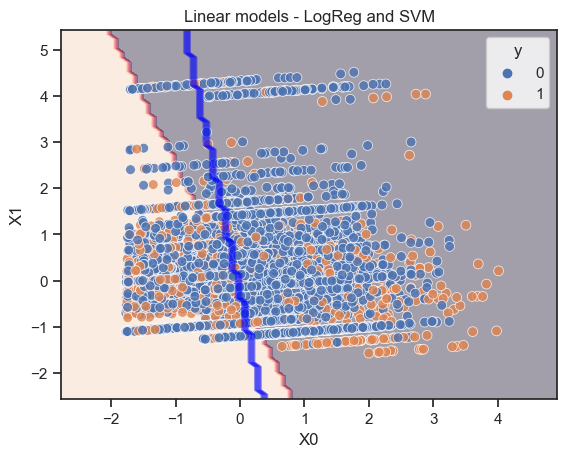

In [138]:
## Plotting decision boundary for LR
z1 = lr.predict(np.c_[xx.ravel(), yy.ravel()])
z1 = z1.reshape(xx.shape)

## Plotting decision boundary for SVM
z2 = svm.predict(np.c_[xx.ravel(), yy.ravel()])
z2 = z2.reshape(xx.shape)

# Displaying the result
plt.contourf(xx, yy, z1, alpha=0.4) # LR
plt.contour(xx, yy, z2, alpha=0.4, colors = 'blue') # SVM
#sns.scatterplot(X[:,0], X[:,1], hue = y_train, s = 50, alpha = 0.8)
data_t = pd.DataFrame({'X0': X[:, 0], 'X1': X[:, 1], 'y': y_train})
sns.scatterplot(data=data_t, x='X0', y='X1', hue='y', s=50, alpha=0.8)
plt.title('Linear models - LogReg and SVM')

### More baseline models (Non-linear) : Decision Tree

In [139]:
from sklearn.tree import DecisionTreeClassifier

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [140]:
weights_dict = {0: 1.0, 1: 3.92}
weights_dict

{0: 1.0, 1: 3.92}

In [141]:
## Features selected from the RFE process
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'bal_per_product',
 'bal_by_est_salary',
 'age_surname_mean_churn']

In [142]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train[selected_feats_dt].values
X_val = df_val[selected_feats_dt].values
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 8), (7920,))

((1080, 8), (1080,))

In [143]:
clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 4, max_features = None
                            , min_samples_split = 25, min_samples_leaf = 15)

In [144]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=4, min_samples_leaf=15, min_samples_split=25)

In [145]:
## Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by = 'importance', ascending=False)

,features,importance
2,country_France,0.476857
3,country_Germany,0.351836
0,Gender,0.096427
5,NumOfProducts,0.032250
1,IsActiveMember,0.028357
6,Surname_enc,0.011373
4,country_Spain,0.002900
7,tenure_age_ratio,0.000000


##### Evaluating the model - Metrics

In [146]:
## Training metrics
roc_auc_score(y_train, clf.predict(X_train))
recall_score(y_train, clf.predict(X_train))
confusion_matrix(y_train, clf.predict(X_train))
print(classification_report(y_train, clf.predict(X_train)))

0.7514707829672929

0.7369402985074627

array([[4835, 1477],
       [ 423, 1185]], dtype=int64)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      6312
           1       0.45      0.74      0.56      1608

    accuracy                           0.76      7920
   macro avg       0.68      0.75      0.70      7920
weighted avg       0.82      0.76      0.78      7920


In [147]:
## Validation metrics
roc_auc_score(y_val, clf.predict(X_val))
recall_score(y_val, clf.predict(X_val))
confusion_matrix(y_val, clf.predict(X_val))
print(classification_report(y_val, clf.predict(X_val)))

0.7477394758378411

0.7436974789915967

array([[633, 209],
       [ 61, 177]], dtype=int64)

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080


#### Plot decision boundaries of non-linear model

In [148]:
from sklearn.decomposition import PCA

In [149]:
pca = PCA(n_components=2)

In [150]:
## Transforming the dataset using PCA
X = pca.fit_transform(X_train)
y = y_train
X_train.shape
X.shape
y.shape

(7920, 8)

(7920, 2)

(7920,)

In [151]:
## Checking the variance explained by the reduced features
pca.explained_variance_ratio_

array([0.51069916, 0.48930078])

In [152]:
# Creating a mesh region where the boundary will be plotted
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 100),
                     np.arange(y_min, y_max, 100))

In [153]:
## Fitting tree model on 2 features
clf.fit(X, y)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=4, min_samples_leaf=15, min_samples_split=25)

<Axes: xlabel='X0', ylabel='X1'>

Text(0.5, 1.0, 'Decision Tree')

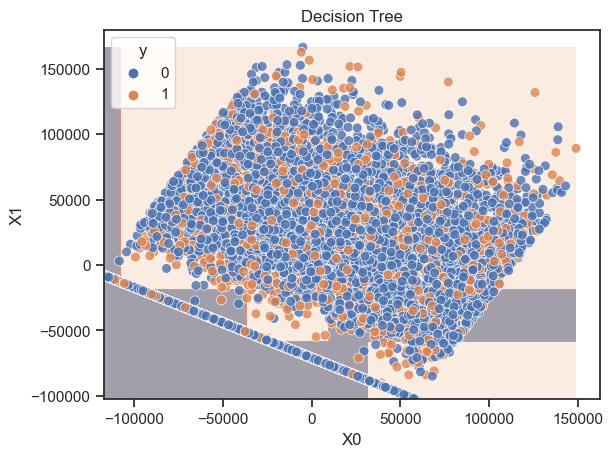

In [155]:
## Plotting decision boundary for Decision Tree (DT)
z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# Displaying the result
plt.contourf(xx, yy, z, alpha=0.4) # DT
#sns.scatterplot(X[:,0], X[:,1], hue = y_train, s = 50, alpha = 0.8)
data_d = pd.DataFrame({'X0': X[:, 0], 'X1': X[:, 1], 'y': y_train})
sns.scatterplot(data=data_d, x='X0', y='X1', hue='y', s=50, alpha=0.8)
plt.title('Decision Tree')

#### Decision tree rule engine visualization

In [156]:
from sklearn.tree import export_graphviz
import subprocess

In [157]:
clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 3, max_features = None
                            , min_samples_split = 25, min_samples_leaf = 15)

clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=3, min_samples_leaf=15, min_samples_split=25)

In [158]:
## Export as dot file
dot_data = export_graphviz(clf, out_file = 'tree.dot'
                          , feature_names = selected_feats_dt
                          , class_names = ['Did not churn', 'Churned']
                          , rounded = True, proportion = False
                          , precision = 2, filled = True)

In [159]:
## Convert to png using system command (requires Graphviz)
#subprocess.run(['dot', '-Tpng','tree.dot', '-o', 'tree.png', '-Gdpi=600'])

In [160]:
## Display the rule-set of a single tree
#from IPython.display import Image
#Image(filename = 'tree.png')

### Spot-checking various ML algorithms

__Steps__ :

- Automate data preparation and model run through Pipelines

- Model Zoo : List of all models to compare/spot-check

- Evaluate using k-fold Cross validation framework

__Note__ : Restart the kernel and read the original dataset again followed by train-test split and then come directly to this section of the notebook

#### Automating data preparation and model run through Pipelines

In [161]:
from sklearn.base import BaseEstimator, TransformerMixin

In [162]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """ 
    Encodes categorical columns using LabelEncoding, OneHotEncoding and TargetEncoding.
    LabelEncoding is used for binary categorical columns
    OneHotEncoding is used for columns with <= 10 distinct values
    TargetEncoding is used for columns with higher cardinality (>10 distinct values)
    
    """

    def __init__(self, cols = None, lcols = None, ohecols = None, tcols = None, reduce_df = False):
        """
        
        Parameters
        ----------
        cols : list of str
            Columns to encode.  Default is to one-hot/target/label encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N 
            categories). E.g. for a column with categories A, B, 
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0], 
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False
        
        """
        
        if isinstance(cols,str):
            self.cols = [cols]
        else :
            self.cols = cols
        
        if isinstance(lcols,str):
            self.lcols = [lcols]
        else :
            self.lcols = lcols
        
        if isinstance(ohecols,str):
            self.ohecols = [ohecols]
        else :
            self.ohecols = ohecols
        
        if isinstance(tcols,str):
            self.tcols = [tcols]
        else :
            self.tcols = tcols
        
        self.reduce_df = reduce_df
    
    
    def fit(self, X, y):
        """Fit label/one-hot/target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')
        
        # Separating out lcols, ohecols and tcols
        if self.lcols is None:
            self.lcols = [c for c in self.cols if X[c].nunique() <= 2]
        
        if self.ohecols is None:
            self.ohecols = [c for c in self.cols if ((X[c].nunique() > 2) & (X[c].nunique() <= 10))]
        
        if self.tcols is None:
            self.tcols = [c for c in self.cols if X[c].nunique() > 10]
        
        
        ## Create Label Encoding mapping
        self.lmaps = dict()
        for col in self.lcols:
            self.lmaps[col] = dict(zip(X[col].values, X[col].astype('category').cat.codes.values))
        
        
        ## Create OneHot Encoding mapping
        self.ohemaps = dict() #dict to store map for each column
        for col in self.ohecols:
            self.ohemaps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.ohemaps[col].append(unique)
            if self.reduce_df:
                del self.ohemaps[col][-1]
        
        
        ## Create Target Encoding mapping
        self.global_target_mean = y.mean().round(2)
        self.sum_count = dict()
        for col in self.tcols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(),ix.sum())
        
        
        ## Return the fit object
        return self
    
    
    def transform(self, X, y=None):
        """Perform label/one-hot/target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        Xo = X.copy()
        ## Perform label encoding transformation
        for col, lmap in self.lmaps.items():
            
            # Map the column
            Xo[col] = Xo[col].map(lmap)
            Xo[col].fillna(-1, inplace=True) ## Filling new values with -1
        
        
        ## Perform one-hot encoding transformation
        for col, vals in self.ohemaps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        
        
        ## Perform LOO target encoding transformation
        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = (sum_count[0]/sum_count[1]).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    if sum_count[1] > 1:
                        vals[ix] = ((sum_count[0]-y[ix].reshape(-1,))/(sum_count[1]-1)).round(2)
                    else :
                        vals[ix] = ((y.sum() - y[ix])/(X.shape[0] - 1)).round(2) # Catering to the case where a particular 
                                                                                 # category level occurs only once in the dataset
                
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean
        
        
        ## Return encoded DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label/one-hot/target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        return self.fit(X, y).transform(X, y)
    


In [163]:
class AddFeatures(BaseEstimator):
    """
    Add new, engineered features using original categorical and numerical features of the DataFrame
    """
    
    def __init__(self, eps = 1e-6):
        """
        Parameters
        ----------
        eps : A small value to avoid divide by zero error. Default value is 0.000001
        """
        
        self.eps = eps
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        Xo = X.copy()
        ## Add 4 new columns - bal_per_product, bal_by_est_salary, tenure_age_ratio, age_surname_mean_churn
        Xo['bal_per_product'] = Xo.Balance/(Xo.NumOfProducts + self.eps)
        Xo['bal_by_est_salary'] = Xo.Balance/(Xo.EstimatedSalary + self.eps)
        Xo['tenure_age_ratio'] = Xo.Tenure/(Xo.Age + self.eps)
        Xo['age_surname_enc'] = np.sqrt(Xo.Age) * Xo.Surname_enc
        
        ## Returning the updated dataframe
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        return self.fit(X,y).transform(X)
    
    

In [164]:
class CustomScaler(BaseEstimator, TransformerMixin):
    """
    A custom standard scaler class with the ability to apply scaling on selected columns
    """
    
    def __init__(self, scale_cols = None):
        """
        Parameters
        ----------
        scale_cols : list of str
            Columns on which to perform scaling and normalization. Default is to scale all numerical columns
        
        """
        self.scale_cols = scale_cols
    
    
    def fit(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        
        # Scaling all non-categorical columns if user doesn't provide the list of columns to scale
        if self.scale_cols is None:
            self.scale_cols = [c for c in X if ((str(X[c].dtype).find('float') != -1) or (str(X[c].dtype).find('int') != -1))]
        
     
        ## Create mapping corresponding to scaling and normalization
        self.maps = dict()
        for col in self.scale_cols:
            self.maps[col] = dict()
            self.maps[col]['mean'] = np.mean(X[col].values).round(2)
            self.maps[col]['std_dev'] = np.std(X[col].values).round(2)
        
        # Return fit object
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        Xo = X.copy()
        
        ## Map transformation to respective columns
        for col in self.scale_cols:
            Xo[col] = (Xo[col] - self.maps[col]['mean']) / self.maps[col]['std_dev']
        
        
        # Return scaled and normalized DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        # Fit and return transformed dataframe
        return self.fit(X).transform(X)
    
    

#### Pipeline in action for a single model

In [165]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [166]:
X = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

In [167]:
weights_dict = {0 : 1.0, 1 : 3.92}

clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 4, max_features = None
                            , min_samples_split = 25, min_samples_leaf = 15)

In [168]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('standard_scaling', CustomScaler(cols_to_scale)),
                          ('classifier', clf)
                         ])

In [169]:
# Fit pipeline with training data
model.fit(X,y_train)

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('standard_scaling',
                 CustomScaler(scale_cols=['CreditScore', 'Age', 'Balance',
                                          'EstimatedSalary', 'bal_per_product',
                                          'bal_by_est_salary',
                                          'tenure_age_ratio',
                                          'age_surname_enc'])),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92},
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=15,
                                        min_samples_split=25))])

In [170]:
# Predict target values on val data
val_preds = model.predict(X_val)

In [171]:
## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

0.7477394758378411

0.7436974789915967

array([[633, 209],
       [ 61, 177]], dtype=int64)

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080


### Model Zoo + k-fold Cross Validation

Models : RF, LGBM, XGB, Naive Bayes (Gaussian/Multinomial), kNN

#### How are models selected ?

 - Why only tree models ? Why not SVM or ANNs?

In [172]:
from sklearn.model_selection import cross_val_score

In [173]:
## Preparing data and a few common model parameters
X = df_train.drop(columns = ['Exited'], axis = 1)
y = y_train.ravel()

weights_dict = {0 : 1.0, 1 : 3.93}
_, num_samples = np.unique(y_train, return_counts = True)
weight = (num_samples[0]/num_samples[1]).round(2)
weight

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

3.93

In [174]:
## Importing the models to be tried out
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

Read more about XGB parameters from here  : https://xgboost.readthedocs.io/en/latest/parameter.html

Tips to tune parameters for LightGBM : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [175]:
## Preparing a list of models to try out in the spot-checking process
def model_zoo(models = dict()):
    # Tree models
    for n_trees in [21, 1001]:
        models['rf_' + str(n_trees)] = RandomForestClassifier(n_estimators = n_trees, n_jobs = -1, criterion = 'entropy'
                                                              , class_weight = weights_dict, max_depth = 6, max_features = 0.6
                                                              , min_samples_split = 30, min_samples_leaf = 20)
        
        models['lgb_' + str(n_trees)] = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth= 6, learning_rate=0.1
                                                       , n_estimators=n_trees, class_weight=weights_dict, min_child_samples=20
                                                       , colsample_bytree=0.6, reg_alpha=0.3, reg_lambda=1.0, n_jobs=- 1
                                                       , importance_type = 'gain')
        
        models['xgb_' + str(n_trees)] = XGBClassifier(objective='binary:logistic', n_estimators = n_trees, max_depth = 6
                                                      , learning_rate = 0.03, n_jobs = -1, colsample_bytree = 0.6
                                                      , reg_alpha = 0.3, reg_lambda = 0.1, scale_pos_weight = weight)
        
        models['et_' + str(n_trees)] = ExtraTreesClassifier(n_estimators=n_trees, criterion = 'entropy', max_depth = 6
                                                            , max_features = 0.6, n_jobs = -1, class_weight = weights_dict
                                                            , min_samples_split = 30, min_samples_leaf = 20)
    
    # kNN models
    for n in [3,5,11]:
        models['knn_' + str(n)] = KNeighborsClassifier(n_neighbors=n)
    
    # Naive-Bayes models
    models['gauss_nb'] = GaussianNB()
    models['multi_nb'] = MultinomialNB()
    models['compl_nb'] = ComplementNB()
    models['bern_nb'] = BernoulliNB()
    
    return models

In [176]:
## Automation of data preparation and model run through pipelines
def make_pipeline(model):
    '''
    Creates pipeline for the model passed as the argument. Uses standard scaling only in case of kNN models. 
    Ignores scaling step for tree/Naive Bayes models
    '''
    
    if (str(model).find('KNeighborsClassifier') != -1):
        pipe =  Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                              ('add_new_features', AddFeatures()),
                              ('standard_scaling', CustomScaler(cols_to_scale)),
                              ('classifier', model)
                             ])
    else :
        pipe =  Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                              ('add_new_features', AddFeatures()),
                              ('classifier', model)
                             ])
    
    
    return pipe


In [177]:
## Run/Evaluate all 15 models using KFold cross-validation (5 folds)
def evaluate_models(X, y, models, folds = 5, metric = 'recall'):
    results = dict()
    for name, model in models.items():
        # Evaluate model through automated pipelines
        pipeline = make_pipeline(model)
        scores = cross_val_score(pipeline, X, y, cv = folds, scoring = metric, n_jobs = -1)
        
        # Store results of the evaluated model
        results[name] = scores
        mu, sigma = np.mean(scores), np.std(scores)
        # Printing individual model results
        print('Model {}: mean = {}, std_dev = {}'.format(name, mu, sigma))
    
    return results
        

In [178]:
## Spot-checking in action
models = model_zoo()
print('Recall metric')
results = evaluate_models(X, y , models, metric = 'recall')
print('F1-score metric')
results = evaluate_models(X, y , models, metric = 'f1')

Recall metric
Model rf_21: mean = 0.7530968828002554, std_dev = 0.024794938866244186
Model lgb_21: mean = 0.7866856291480427, std_dev = 0.015745566437193475
Model xgb_21: mean = 0.7692594957527912, std_dev = 0.02427969281921412
Model et_21: mean = 0.7350728507575317, std_dev = 0.006098791127381404
Model rf_1001: mean = 0.7493604999903252, std_dev = 0.024310795228393533
Model lgb_1001: mean = 0.6884232116251622, std_dev = 0.014573973874519829
Model xgb_1001: mean = 0.6772334126661635, std_dev = 0.011687132255824195
Model et_1001: mean = 0.7344536676921886, std_dev = 0.0036410830351994005
Model knn_3: mean = nan, std_dev = nan
Model knn_5: mean = nan, std_dev = nan
Model knn_11: mean = nan, std_dev = nan
Model gauss_nb: mean = 0.0360906329211896, std_dev = 0.0151162576177723
Model multi_nb: mean = 0.5404191095373541, std_dev = 0.022285871235774777
Model compl_nb: mean = 0.5404191095373541, std_dev = 0.022285871235774777
Model bern_nb: mean = 0.31030552814380524, std_dev = 0.0222015969522

Based on the relevant metric, a suitable model can be chosen for further hyperparameter tuning.

LightGBM is chosen for further hyperparameter tuning because it has the best performance on recall metric and it came close second when comparing using F1-scores

### Hyperparameter tuning

RandomSearchCV vs GridSearchCV

- Random Search is more suitable for large datasets, with a large number of parameter settings
- Grid Search results in a more precise hyperparameter tuning, thus resulting in better model performance. Intelligent tuning mechanism can also help reduce the time taken in GridSearch by a large factor

- Will optimize on F1 metric. We could easily reach 75% Recall from the default parameters as seen earlier



In [179]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

In [180]:
## Preparing data and a few common model parameters
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [181]:
lgb = LGBMClassifier(boosting_type = 'dart', min_child_samples = 20, n_jobs = - 1, importance_type = 'gain', num_leaves = 31)

In [182]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb)
                         ])

#### Randomized Search

In [183]:
## Exhaustive list of parameters
parameters = {'classifier__n_estimators':[10, 21, 51, 100, 201, 350, 501]
             ,'classifier__max_depth': [3, 4, 6, 9]
             ,'classifier__num_leaves':[7, 15, 31] 
             ,'classifier__learning_rate': [0.03, 0.05, 0.1, 0.5, 1]
             ,'classifier__colsample_bytree': [0.3, 0.6, 0.8]
             ,'classifier__reg_alpha': [0, 0.3, 1, 5]
             ,'classifier__reg_lambda': [0.1, 0.5, 1, 5, 10]
             ,'classifier__class_weight': [{0:1,1:1.0}, {0:1,1:1.96}, {0:1,1:3.0}, {0:1,1:3.93}]
             }

In [184]:
search = RandomizedSearchCV(model, parameters, n_iter = 20, cv = 5, scoring = 'f1')

In [185]:
search.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1287, number of negative: 5049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 6336, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333159 -> initscore=-0.693932
[LightGBM] [Info] Start training from score -0.693932
[LightGBM] [Info] Number of positive: 1287, number of negative: 5049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 6336, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333159 -> initscore=-0.693932
[LightGBM] [Info] Start training from score -0.693932
[LightGBM] [

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('categorical_encoding',
                                              CategoricalEncoder()),
                                             ('add_new_features',
                                              AddFeatures()),
                                             ('classifier',
                                              LGBMClassifier(boosting_type='dart',
                                                             importance_type='gain',
                                                             n_jobs=-1))]),
                   n_iter=20,
                   param_distributions={'classifier__class_weight': [{0: 1,
                                                                      1: 1.0},
                                                                     {0: 1,
                                                                      1: 1.96},
                                                                     {0: 1,
                                                                      1: 3.0},
                                                                     {0: 1,
                                                                      1: 3.93}],
                                        'classifier__colsample_bytree': [0.3,
                                                                         0.6,
                                                                         0.8],
                                        'classifier__learning_rate': [0.03,
                                                                      0.05, 0.1,
                                                                      0.5, 1],
                                        'classifier__max_depth': [3, 4, 6, 9],
                                        'classifier__n_estimators': [10, 21, 51,
                                                                     100, 201,
                                                                     350, 501],
                                        'classifier__num_leaves': [7, 15, 31],
                                        'classifier__reg_alpha': [0, 0.3, 1, 5],
                                        'classifier__reg_lambda': [0.1, 0.5, 1,
                                                                   5, 10]},
                   scoring='f1')

In [186]:
search.best_params_
search.best_score_

{'classifier__reg_lambda': 0.1,
 'classifier__reg_alpha': 0.3,
 'classifier__num_leaves': 7,
 'classifier__n_estimators': 51,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.5,
 'classifier__colsample_bytree': 0.6,
 'classifier__class_weight': {0: 1, 1: 1.96}}

0.687804019711465

In [187]:
search.cv_results_

{'mean_fit_time': array([0.08258414, 0.06834464, 0.17048469, 0.2473237 , 0.07154264,
        0.04090247, 0.07445383, 0.11239014, 0.03190904, 0.06111989,
        1.56488557, 1.47697792, 1.5570322 , 1.51892204, 1.25188675,
        0.57023292, 1.69709702, 1.41627154, 3.01077747, 2.21761336]),
 'std_fit_time': array([8.05932761e-02, 3.57110318e-03, 1.42732218e-02, 2.60363954e-02,
        1.02140262e-02, 2.89987502e-03, 1.96735683e-03, 4.21764230e-02,
        7.93956040e-04, 1.45939557e-03, 6.19365987e-02, 1.85246799e-01,
        2.01563755e-01, 3.57594581e-01, 9.39801511e-02, 1.83176129e-01,
        1.04313861e+00, 5.78621530e-01, 7.19728275e-01, 2.96282283e-01]),
 'mean_score_time': array([0.01270466, 0.01299782, 0.01693645, 0.01620851, 0.01410027,
        0.01349955, 0.01340427, 0.01510239, 0.01169877, 0.01330028,
        0.02264428, 0.02510862, 0.02460794, 0.02530603, 0.02682133,
        0.02100716, 0.02952199, 0.0238554 , 0.07108316, 0.04802384]),
 'std_score_time': array([0.00259675, 

#### Grid Search

In [188]:
## Current list of parameters
parameters = {'classifier__n_estimators':[201]
             ,'classifier__max_depth': [6]
             ,'classifier__num_leaves': [63]
             ,'classifier__learning_rate': [0.1]
             ,'classifier__colsample_bytree': [0.6, 0.8]
             ,'classifier__reg_alpha': [0, 1, 10]
             ,'classifier__reg_lambda': [0.1, 1, 5]
             ,'classifier__class_weight': [{0:1,1:3.0}]
             }

In [189]:
grid = GridSearchCV(model, parameters, cv = 5, scoring = 'f1', n_jobs = -1)

In [190]:
grid.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical_encoding',
                                        CategoricalEncoder()),
                                       ('add_new_features', AddFeatures()),
                                       ('classifier',
                                        LGBMClassifier(boosting_type='dart',
                                                       importance_type='gain',
                                                       n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [{0: 1, 1: 3.0}],
                         'classifier__colsample_bytree': [0.6, 0.8],
                         'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [6],
                         'classifier__n_estimators': [201],
                         'classifier__num_leaves': [63],
                         'classifier__reg_alpha': [0, 1, 10],
                         'classifier__reg_lambda': [0.1, 1, 5]},
             scoring='f1')

In [191]:
grid.best_params_
grid.best_score_

{'classifier__class_weight': {0: 1, 1: 3.0},
 'classifier__colsample_bytree': 0.6,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 6,
 'classifier__n_estimators': 201,
 'classifier__num_leaves': 63,
 'classifier__reg_alpha': 1,
 'classifier__reg_lambda': 1}

0.6827227378996369

In [192]:
grid.cv_results_

{'mean_fit_time': array([ 6.11025987,  5.98195696,  8.19574142,  7.57475104,  5.52687783,
         6.12115369,  6.05891757,  5.36264811,  5.54548421,  9.13978858,
        10.43370423,  8.85466585,  8.24161086,  6.32237353,  5.40590343,
         5.55893168,  5.31788745,  4.91245732]),
 'std_fit_time': array([0.955135  , 0.98469558, 0.67805134, 0.83675743, 0.9788318 ,
        1.2575847 , 1.21462036, 0.37294309, 0.20648352, 0.97986827,
        0.52783771, 1.08565757, 1.28619441, 0.62749221, 0.05054345,
        0.51546539, 0.41928685, 0.24677223]),
 'mean_score_time': array([0.03171105, 0.03310814, 0.03445301, 0.02330289, 0.02640252,
        0.03032928, 0.02250209, 0.02391539, 0.02822194, 0.04311528,
        0.03451638, 0.03022814, 0.02551026, 0.02230854, 0.02101445,
        0.023804  , 0.02611055, 0.03544831]),
 'std_score_time': array([0.00645213, 0.00798475, 0.00857362, 0.00222854, 0.00733468,
        0.01265099, 0.00141603, 0.00182734, 0.00445944, 0.00912425,
        0.00360159, 0.0047

### Can we do better? - Ensembles

In [193]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

In [194]:
## Preparing data for error analysis
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [195]:
## Three versions of the final model with best params for F1-score metric

# Equal weights to both target classes (no class imbalance correction)
lgb1 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 1}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 4, num_leaves = 31, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 21, reg_alpha = 0, reg_lambda = 0.5)

# Addressing class imbalance completely by weighting the undersampled class by the class imbalance ratio
lgb2 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.93}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


# Best class_weight parameter settings (partial class imbalance correction)
lgb3 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


In [196]:
## 3 different Pipeline objects for the 3 models defined above
model_1 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb1)
                         ])

model_2 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb2)
                         ])

model_3 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb3)
                         ])

In [197]:
## Fitting each of these models
model_1.fit(X_train, y_train.ravel())
model_2.fit(X_train, y_train.ravel())
model_3.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203030 -> initscore=-1.367461
[LightGBM] [Info] Start training from score -1.367461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 1},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=4, n_estimators=21, n_jobs=-1,
                                reg_alpha=0, reg_lambda=0.5))])

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500295 -> initscore=0.001178
[LightGBM] [Info] Start training from score 0.001178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.93},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

In [198]:
## Getting prediction probabilities from each of these models
m1_pred_probs_trn = model_1.predict_proba(X_train)
m2_pred_probs_trn = model_2.predict_proba(X_train)
m3_pred_probs_trn = model_3.predict_proba(X_train)

In [199]:
## Checking correlations between the predictions of the 3 models
df_t = pd.DataFrame({'m1_pred': m1_pred_probs_trn[:,1], 'm2_pred': m2_pred_probs_trn[:,1], 'm3_pred': m3_pred_probs_trn[:,1]})
df_t.shape
df_t.corr()

(7920, 3)

,m1_pred,m2_pred,m3_pred
m1_pred,1.000000,0.894747,0.911251
m2_pred,0.894747,1.000000,0.994593
m3_pred,0.911251,0.994593,1.000000


Although models m1 and m2 are highly correlated (0.9), they are still less closely associated than m2 and m3.
Thus, we'll try to form an ensemble of m1 and m2 (model averaging/stacking) and see if that improves the model accuracy

In [200]:
## Importing relevant metric libraries
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [201]:
## Getting prediction probabilities from each of these models
m1_pred_probs_val = model_1.predict_proba(X_val)
m2_pred_probs_val = model_2.predict_proba(X_val)
m3_pred_probs_val = model_3.predict_proba(X_val)

In [202]:
threshold = 0.5

In [203]:
## Best model (Model 3) predictions
m3_preds = np.where(m3_pred_probs_val[:,1] >= threshold, 1, 0)

In [204]:
## Model averaging predictions (Weighted average)
m1_m2_preds = np.where(((0.1*m1_pred_probs_val[:,1]) + (0.9*m2_pred_probs_val[:,1])) >= threshold, 1, 0)

In [205]:
## Model 3 (Best model, tuned by GridSearch) performance on validation set
roc_auc_score(y_val, m3_preds)
recall_score(y_val, m3_preds)
confusion_matrix(y_val, m3_preds)
print(classification_report(y_val, m3_preds))

0.7469310764685922

0.592436974789916

array([[759,  83],
       [ 97, 141]], dtype=int64)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       842
           1       0.63      0.59      0.61       238

    accuracy                           0.83      1080
   macro avg       0.76      0.75      0.75      1080
weighted avg       0.83      0.83      0.83      1080


In [206]:
## Ensemble model prediction on validation set
roc_auc_score(y_val, m1_m2_preds)
recall_score(y_val, m1_m2_preds)
confusion_matrix(y_val, m1_m2_preds)
print(classification_report(y_val, m1_m2_preds))

0.7586678376813908

0.6218487394957983

array([[754,  88],
       [ 90, 148]], dtype=int64)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       842
           1       0.63      0.62      0.62       238

    accuracy                           0.84      1080
   macro avg       0.76      0.76      0.76      1080
weighted avg       0.83      0.84      0.83      1080


#### Model stacking

The base models are the 2 LightGBM models with different class_weights parameters. They are stacked on top by a logistic regression model. Other models like linear SVM/Decision Trees can also be used. But since there are only 2 features for the model at stacking layer, it's better to use the simplest model available.

For training, we have the predictions from the 2 models on the train set. They go in as the input to the next layer of the Ensemble, which is the logistic regression model, and train the LogReg model

For prediction, we first predict using the 2 LGBM models on the validation set. The predictions from the two models go as inputs to the logistic regression which gives out the final prediction

In [207]:
from sklearn.linear_model import LogisticRegression

In [208]:
## Training
lr = LogisticRegression(C = 1.0, class_weight =  {0:1, 1:2.0})

# Concatenating the probability predictions of the 2 models on train set
X_t = np.c_[m1_pred_probs_trn[:,1],m2_pred_probs_trn[:,1]] 

# Fit stacker model on top of outputs of base model
lr.fit(X_t, y_train)

LogisticRegression(class_weight={0: 1, 1: 2.0})

In [209]:
## Prediction
# Concatenating outputs from both the base models on the validation set
X_t_val = np.c_[m1_pred_probs_val[:,1],m2_pred_probs_val[:,1]]

# Predict using the stacker model
m1_m2_preds = lr.predict(X_t_val)

In [210]:
## Ensemble model prediction on validation set
roc_auc_score(y_val, m1_m2_preds)
recall_score(y_val, m1_m2_preds)
confusion_matrix(y_val, m1_m2_preds)
print(classification_report(y_val, m1_m2_preds))

0.7463372522405638

0.592436974789916

array([[758,  84],
       [ 97, 141]], dtype=int64)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       842
           1       0.63      0.59      0.61       238

    accuracy                           0.83      1080
   macro avg       0.76      0.75      0.75      1080
weighted avg       0.83      0.83      0.83      1080


In [211]:
# Model weights learnt by the stacker LogReg model
lr.coef_
lr.intercept_

array([[-6.06252409, 12.94656529]])

array([-5.65280526])

### Error analysis

In [212]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

In [213]:
## Preparing data for error analysis
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [214]:
## Final model with best params for F1-score metric

lgb = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb)
                         ])

In [215]:
## Fit best model
model.fit(X_train, y_train.ravel())

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

In [216]:
## Making predictions on a copy of validation set
df_ea = df_val.copy()
df_ea['y_pred'] = model.predict(X_val)
df_ea['y_pred_prob'] = model.predict_proba(X_val)[:,1]

In [217]:
df_ea.shape
df_ea.sample(5)

(1080, 20)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,y_pred,y_pred_prob
489,655,1,38,9,0.00,1,0,1,90490.33,0,0.0,0.0,1.0,0.222222,0.000000,0.000000,0.236842,1.369870,0,0.191367
172,694,0,37,8,98218.04,2,1,0,182354.46,1,0.0,1.0,0.0,0.000000,49108.995446,0.538611,0.216216,0.000000,0,0.255683
803,716,1,31,8,109578.04,2,1,1,51503.51,0,1.0,0.0,0.0,0.000000,54788.992606,2.127584,0.258065,0.000000,0,0.209394
1072,697,1,43,8,103409.16,1,1,0,66893.28,1,0.0,1.0,0.0,0.500000,103409.056591,1.545883,0.186047,3.278719,1,0.637184
826,502,1,33,7,0.00,2,0,1,4082.52,0,1.0,0.0,0.0,0.203030,0.000000,0.000000,0.212121,1.166320,0,0.018017


In [218]:
## Visualizing distribution of predicted probabilities
sns.violinplot(y_val.ravel(), df_ea['y_pred_prob'].values)

TypeError: violinplot() takes from 0 to 1 positional arguments but 2 were given

#### Revisiting bivariate plots of important features

The difference in distribution of these features across the two classes help us to test a few hypotheses

<Axes: xlabel='Exited', ylabel='Age'>

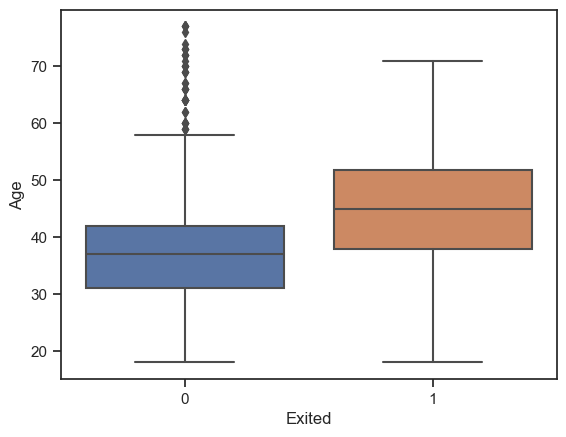

In [219]:
sns.boxplot(x = 'Exited', y = 'Age', data = df_ea)

In [220]:
## Are we able to correctly identify pockets of high-churn customer regions in feature space?
df_ea.Exited.value_counts(normalize=True).sort_index()
df_ea[(df_ea.Age > 42) & (df_ea.Age < 53)].Exited.value_counts(normalize=True).sort_index()
df_ea[(df_ea.Age > 42) & (df_ea.Age < 53)].y_pred.value_counts(normalize=True).sort_index()

Exited
0    0.77963
1    0.22037
Name: proportion, dtype: float64

Exited
0    0.560185
1    0.439815
Name: proportion, dtype: float64

y_pred
0    0.481481
1    0.518519
Name: proportion, dtype: float64

In [221]:
## Checking correlation between features and target variable vs predicted variable
x = df_ea[num_feats + ['y_pred', 'Exited']].corr()
x[['y_pred','Exited']]

,y_pred,Exited
CreditScore,-0.016600,-0.026118
Age,0.364415,0.290853
Tenure,-0.015095,-0.011182
Balance,0.065750,0.128656
NumOfProducts,-0.150982,-0.125494
EstimatedSalary,0.006502,-0.007971
y_pred,1.000000,0.504881
Exited,0.504881,1.000000


#### Extracting the subset of incorrect predictions

All incorrect predictions are extracted and categorized into false positives (low precision) and false negatives (low recall)

In [222]:
low_recall = df_ea[(df_ea.Exited == 1) & (df_ea.y_pred == 0)]
low_prec = df_ea[(df_ea.Exited == 0) & (df_ea.y_pred == 1)]
low_recall.shape
low_prec.shape
low_recall.head()
low_prec.head()

(97, 20)

(83, 20)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,y_pred,y_pred_prob
5,706,0,23,5,0.00,1,0,0,164128.41,1,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.217391,0.000000,0,0.376791
21,611,1,35,10,0.00,1,1,1,23598.23,1,1.0,0.0,0.0,0.153846,0.000000,0.000000,0.285714,0.910166,0,0.261700
38,491,0,68,1,95039.12,1,0,1,116471.14,1,0.0,1.0,0.0,0.000000,95039.024961,0.815989,0.014706,0.000000,0,0.417236
58,637,1,43,1,135645.29,2,0,1,101382.86,1,0.0,1.0,0.0,0.090909,67822.611089,1.337951,0.023256,0.596131,0,0.481300
92,717,0,36,2,99472.76,2,1,0,94274.72,1,1.0,0.0,0.0,0.222222,49736.355132,1.055137,0.055556,1.333333,0,0.092277


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,y_pred,y_pred_prob
48,512,1,39,3,0.00,1,1,0,134878.19,0,0.0,0.0,1.0,0.083333,0.000000,0.000000,0.076923,0.520416,1,0.597483
49,736,1,43,4,202443.47,1,1,0,72375.03,0,1.0,0.0,0.0,0.000000,202443.267557,2.797145,0.093023,0.000000,1,0.654514
57,505,1,43,6,127146.68,1,0,0,137565.87,0,0.0,1.0,0.0,0.090909,127146.552853,0.924260,0.139535,0.596131,1,0.786853
75,648,1,41,5,123049.21,1,0,1,5066.76,0,0.0,1.0,0.0,0.142857,123049.086951,24.285581,0.121951,0.914732,1,0.668350
99,631,1,51,8,100654.80,1,1,0,171587.90,0,1.0,0.0,0.0,0.500000,100654.699345,0.586608,0.156863,3.570714,1,0.821969


<Axes: xlabel='y_pred_prob', ylabel='Density'>

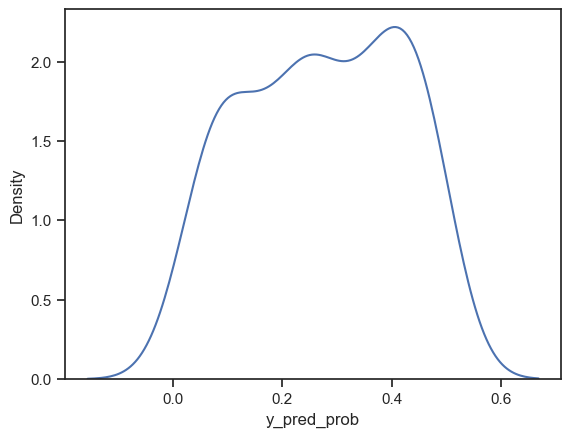

In [223]:
## Prediction probabilty distribution of errors causing low recall
sns.distplot(low_recall.y_pred_prob, hist=False)

<Axes: xlabel='y_pred_prob', ylabel='Density'>

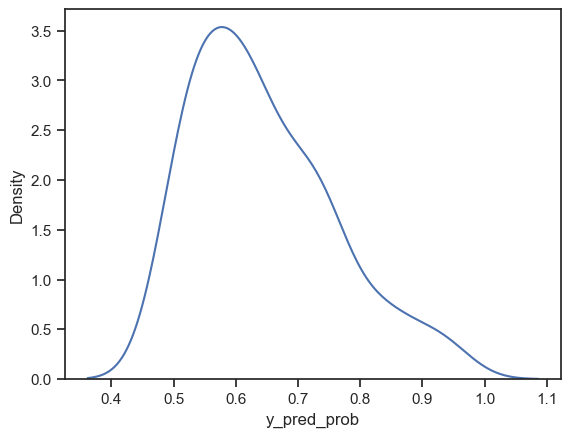

In [224]:
## Prediction probabilty distribution of errors causing low precision
sns.distplot(low_prec.y_pred_prob, hist=False)

#### Tweaking the threshold of classifier

In [225]:
threshold = 0.55

In [226]:
## Predict on validation set with adjustable decision threshold
probs = model.predict_proba(X_val)[:,1]
val_preds = np.where(probs > threshold, 1, 0)

In [227]:
## Default params : 0.5 threshold
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

array([[778,  64],
       [110, 128]], dtype=int64)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       842
           1       0.67      0.54      0.60       238

    accuracy                           0.84      1080
   macro avg       0.77      0.73      0.75      1080
weighted avg       0.83      0.84      0.83      1080


In [228]:
## Tweaking threshold between 0.4 and 0.6
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

array([[778,  64],
       [110, 128]], dtype=int64)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       842
           1       0.67      0.54      0.60       238

    accuracy                           0.84      1080
   macro avg       0.77      0.73      0.75      1080
weighted avg       0.83      0.84      0.83      1080


#### Checking whether there's too much dependence on certain features

We'll compare a few important features : NumOfProducts, IsActiveMember, Age, Balance

In [229]:
df_ea.NumOfProducts.value_counts(normalize=True).sort_index()
low_recall.NumOfProducts.value_counts(normalize=True).sort_index()
low_prec.NumOfProducts.value_counts(normalize=True).sort_index()

NumOfProducts
1    0.506481
2    0.467593
3    0.020370
4    0.005556
Name: proportion, dtype: float64

NumOfProducts
1    0.701031
2    0.288660
3    0.010309
Name: proportion, dtype: float64

NumOfProducts
1    0.819277
2    0.156627
3    0.024096
Name: proportion, dtype: float64

In [230]:
df_ea.IsActiveMember.value_counts(normalize=True).sort_index()
low_recall.IsActiveMember.value_counts(normalize=True).sort_index()
low_prec.IsActiveMember.value_counts(normalize=True).sort_index()

IsActiveMember
0    0.481481
1    0.518519
Name: proportion, dtype: float64

IsActiveMember
0    0.556701
1    0.443299
Name: proportion, dtype: float64

IsActiveMember
0    0.626506
1    0.373494
Name: proportion, dtype: float64

<Axes: ylabel='Age'>

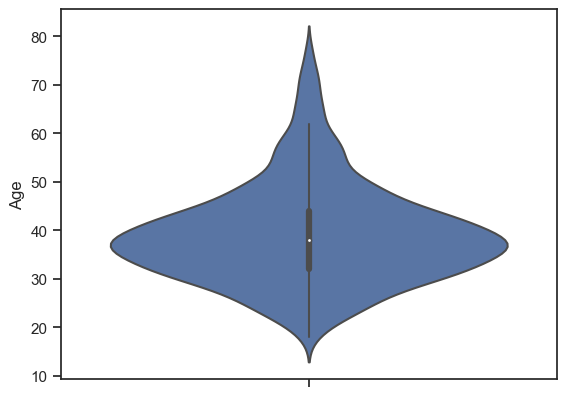

In [231]:
sns.violinplot(y = df_ea.Age)

<Axes: ylabel='Age'>

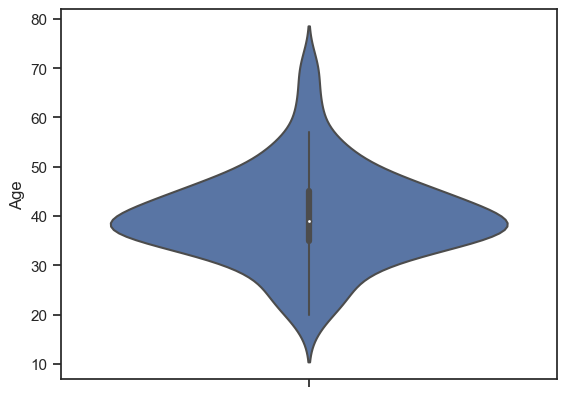

In [232]:
sns.violinplot(y = low_recall.Age)

<Axes: ylabel='Age'>

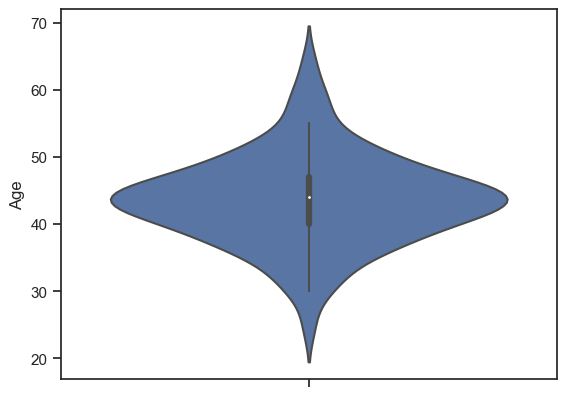

In [233]:
sns.violinplot(y = low_prec.Age)

<Axes: ylabel='Balance'>

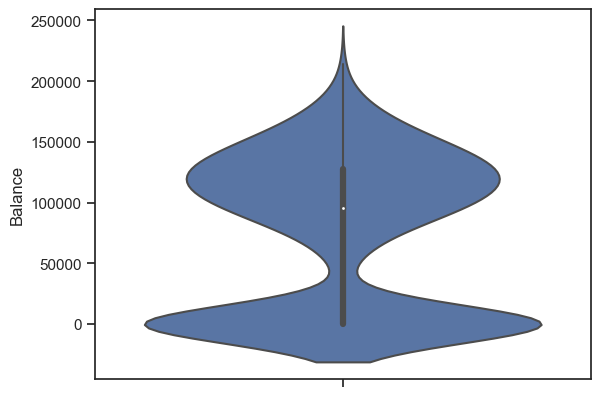

In [234]:
sns.violinplot(y = df_ea.Balance)

<Axes: ylabel='Balance'>

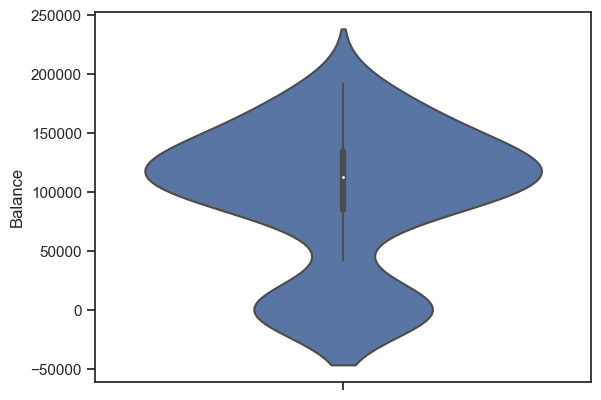

In [235]:
sns.violinplot(y = low_recall.Balance)

<Axes: ylabel='Balance'>

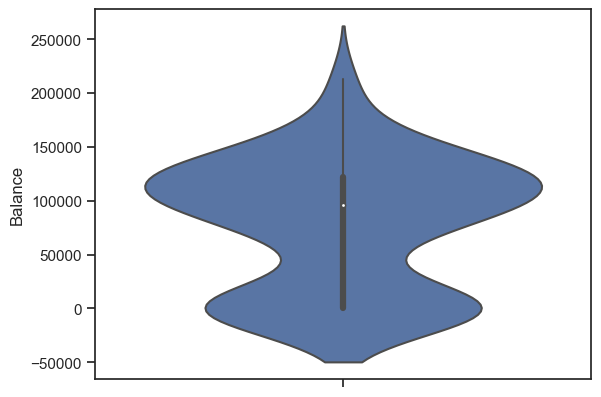

In [236]:
sns.violinplot(y = low_prec.Balance)

### Train final, best model ; Save model and its parameters

In [237]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report
import joblib

In [238]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 17), (7920,))

((1080, 17), (1080,))

In [239]:
best_f1_lgb = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)

In [240]:
best_recall_lgb = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth= 6, learning_rate=0.1, n_estimators = 21
                                 , class_weight= {0: 1, 1: 3.93}, min_child_samples=2, colsample_bytree=0.6, reg_alpha=0.3
                                 , reg_lambda=1.0, n_jobs=- 1, importance_type = 'gain')

In [241]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', best_f1_lgb)
                         ])

In [242]:
## Fitting final model on train dataset
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, n_jobs=-1,
                                num_leaves=63, reg_alpha=1, reg_lambda=1))])

In [243]:
# Predict target probabilities
val_probs = model.predict_proba(X_val)[:,1]

# Predict target values on val data
val_preds = np.where(val_probs > 0.45, 1, 0) # The probability threshold can be tweaked

<Axes: >

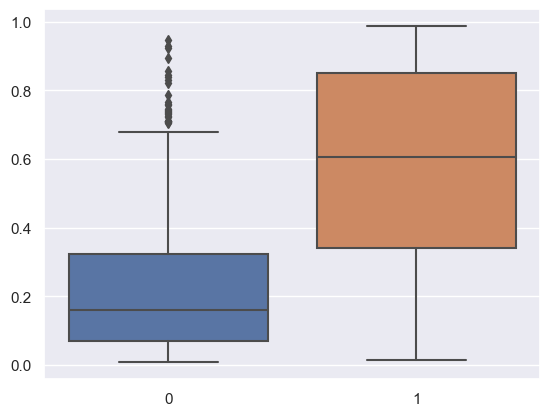

In [273]:
sns.boxplot(x = y_val.ravel(), y = val_probs)

In [245]:
## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

0.7587576598335297

0.6386554621848739

array([[740, 102],
       [ 86, 152]], dtype=int64)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       842
           1       0.60      0.64      0.62       238

    accuracy                           0.83      1080
   macro avg       0.75      0.76      0.75      1080
weighted avg       0.83      0.83      0.83      1080


In [246]:
## Save model object
joblib.dump(model, 'final_churn_model_f1_0_45.sav')

['final_churn_model_f1_0_45.sav']

### SHAP

SHAP paper : https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

In [247]:
import shap

shap.initjs()

In [248]:
ce = CategoricalEncoder()
af = AddFeatures()

X = ce.fit_transform(X_train, y_train)
X = af.transform(X)

In [249]:
X.shape
X.sample(5)

(7920, 18)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,age_surname_enc
2815,561,1,24,8,143656.55,1,0,1,180932.46,0.0,0.0,1.0,0.0,143656.406344,0.793979,0.333333,0.000000,0.000000
7143,627,1,49,4,111087.50,1,0,1,146680.25,0.0,0.0,1.0,0.0,111087.388913,0.757345,0.081633,0.000000,0.000000
1636,586,1,32,1,0.00,2,0,0,31635.99,1.0,0.0,0.0,0.0,0.000000,0.000000,0.031250,0.000000,0.000000
6079,581,0,27,5,102258.11,2,1,0,194681.60,1.0,0.0,0.0,1.0,51129.029435,0.525258,0.185185,5.196152,5.196152
4136,772,0,42,0,101979.16,1,1,0,90928.48,0.0,1.0,0.0,0.0,101979.058021,1.121532,0.000000,0.000000,0.000000


In [250]:
best_f1_lgb.fit(X, y_train)

[LightGBM] [Info] Number of positive: 1608, number of negative: 6312
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433190 -> initscore=-0.268849
[LightGBM] [Info] Start training from score -0.268849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 3.0},
               colsample_bytree=0.6, importance_type='gain', max_depth=6,
               n_estimators=201, n_jobs=-1, num_leaves=63, reg_alpha=1,
               reg_lambda=1)

In [251]:
explainer = shap.TreeExplainer(best_f1_lgb)

In [252]:
X.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,age_surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0.0,1.0,0.0,0.000000,58932.395534,4.267519,0.027778,0.000000,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,1.0,0.0,0.0,0.000000,125167.614832,0.628653,0.185185,0.000000,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.200000,1.490712,1.490712
3,513,1,30,5,0.00,2,1,0,162523.66,1.0,0.0,0.0,0.300000,0.000000,0.000000,0.166667,1.643168,1.643168
4,639,1,22,4,0.00,2,1,0,28188.96,1.0,0.0,0.0,0.500000,0.000000,0.000000,0.181818,2.345208,2.345208
5,562,1,30,3,111099.79,2,0,0,140650.19,1.0,0.0,0.0,0.307692,55549.867225,0.789901,0.100000,1.685300,1.685300
6,635,1,43,5,78992.75,2,0,0,153265.31,0.0,1.0,0.0,0.222222,39496.355252,0.515399,0.116279,1.457209,1.457209
7,705,1,33,7,68423.89,1,1,1,64872.55,0.0,0.0,1.0,0.203056,68423.821576,1.054743,0.212121,1.166468,1.166468
8,694,1,42,8,133767.19,1,1,0,36405.21,1.0,0.0,0.0,0.000000,133767.056233,3.674397,0.190476,0.000000,0.000000
9,711,1,26,9,128793.63,1,1,0,19262.05,0.0,1.0,0.0,0.000000,128793.501206,6.686393,0.346154,0.000000,0.000000


In [253]:
row_num = 7
shap_vals = explainer.shap_values(X.iloc[row_num].values.reshape(1,-1))

In [254]:
#base value
explainer.expected_value

[1.1279613498396024, -1.1279613498396024]

In [255]:
## Explain single prediction
shap.force_plot(explainer.expected_value[1], shap_vals[1], X.iloc[row_num], link = 'logit')

In [256]:
## Check probability predictions through the model
pred_probs = best_f1_lgb.predict_proba(X)[:,1]
pred_probs[row_num]

0.07878111194117235

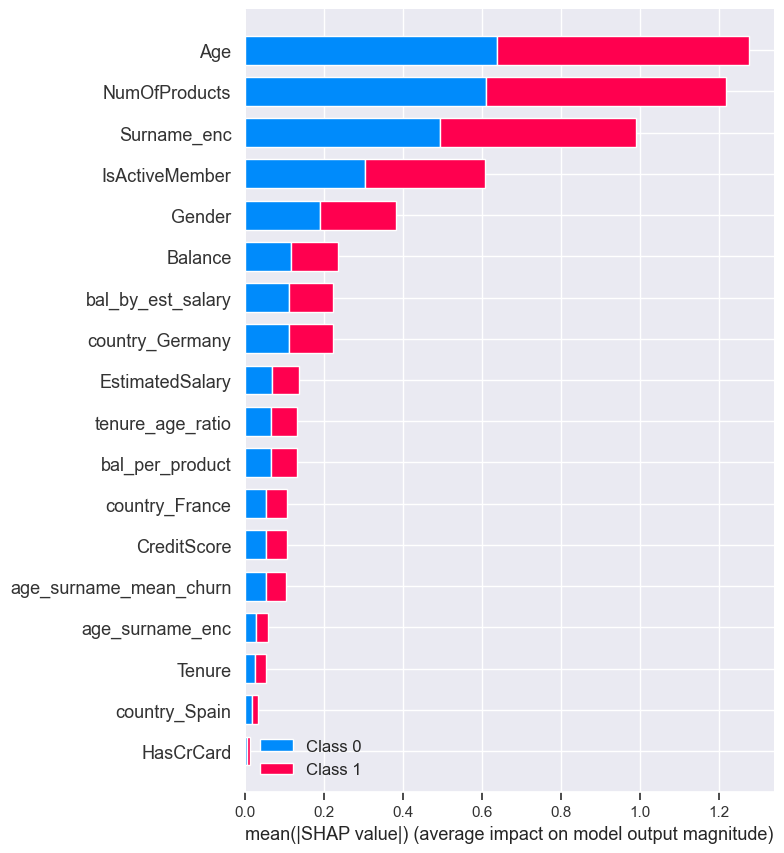

In [257]:
## Explain global patterns/ summary stats
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

### Load saved model and make predictions on unseen/future data

Here, we'll use df_test as the unseen, future data

In [258]:
import joblib

In [259]:
## Load model object
model = joblib.load('final_churn_model_f1_0_45.sav')

In [260]:
X_test = df_test.drop(columns = ['Exited'], axis = 1)
X_test.shape
y_test.shape

(1000, 17)

(1000,)

In [261]:
## Predict target probabilities
test_probs = model.predict_proba(X_test)[:,1]

In [262]:
## Predict target values on test data
test_preds = np.where(test_probs > 0.45, 1, 0) # Flexibility to tweak the probability threshold
#test_preds = model.predict(X_test)

<Axes: >

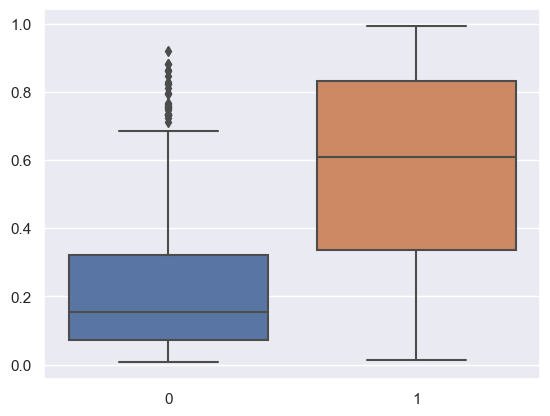

In [266]:
#sns.boxplot(y_test.ravel(), test_probs)

# Use sns.boxplot with x and y specified as keyword arguments
sns.boxplot(y=test_probs, x=y_test.ravel())

In [267]:
## Test set metrics
roc_auc_score(y_test, test_preds)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

0.7678570272911421

0.675392670157068

array([[696, 113],
       [ 62, 129]], dtype=int64)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       809
           1       0.53      0.68      0.60       191

    accuracy                           0.82      1000
   macro avg       0.73      0.77      0.74      1000
weighted avg       0.84      0.82      0.83      1000


In [268]:
## Adding predictions and their probabilities in the original test dataframe
test = df_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs

In [269]:
test.sample(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,predictions,pred_probabilities
390,646,1,50,0,104129.24,2,1,0,181794.86,1,1.0,0.0,0.0,0.166667,52064.593968,0.572784,0.000000,1.178511,1,0.726204
85,482,0,48,2,69329.47,1,0,0,102640.52,1,0.0,1.0,0.0,0.000000,69329.400671,0.675459,0.041667,0.000000,1,0.650329
558,705,0,55,8,0.00,2,1,1,14392.68,0,1.0,0.0,0.0,0.357143,0.000000,0.000000,0.145455,2.648642,0,0.323213
675,678,0,44,2,98009.13,2,0,1,31384.86,0,0.0,1.0,0.0,0.203030,49004.540498,3.122816,0.045455,1.346751,0,0.066472
299,723,0,47,10,90450.00,2,0,0,103379.31,1,0.0,1.0,0.0,0.203030,45224.977388,0.874933,0.212766,1.391906,0,0.174516
33,567,1,36,1,0.00,2,0,0,8555.73,0,1.0,0.0,0.0,0.333333,0.000000,0.000000,0.027778,2.000000,0,0.072156
988,769,1,29,4,145471.37,1,1,0,188382.77,0,1.0,0.0,0.0,0.375000,145471.224529,0.772212,0.137931,2.019437,0,0.228501
520,662,1,32,9,0.00,2,0,0,65089.38,0,1.0,0.0,0.0,1.000000,0.000000,0.000000,0.281250,5.656854,0,0.027817
250,777,0,28,2,134571.50,1,0,1,118313.38,0,1.0,0.0,0.0,0.384615,134571.365429,1.137416,0.071429,2.035193,0,0.277266
617,474,1,54,3,0.00,1,1,0,108409.17,1,1.0,0.0,0.0,0.176471,0.000000,0.000000,0.055556,1.296789,1,0.916539


#### Creating a list of customers who are the most likely to churn

Listing customers who have a churn probability higher than 70%. These are the ones who can be targeted immediately

In [270]:
high_churn_list = test[test.pred_probabilities > 0.7].sort_values(by = ['pred_probabilities'], ascending = False
                                                                 ).reset_index().drop(columns = ['index', 'Exited', 'predictions'], axis = 1)

In [271]:
high_churn_list.shape
high_churn_list.head()

(103, 18)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,pred_probabilities
0,546,0,58,3,106458.31,4,1,0,128881.87,0.0,1.0,0.0,0.000000,26614.570846,0.826015,0.051724,0.000000,0.992935
1,479,1,51,1,107714.74,3,1,0,86128.21,0.0,1.0,0.0,0.333333,35904.901365,1.250633,0.019608,2.380476,0.979605
2,745,1,45,10,117231.63,3,1,1,122381.02,0.0,1.0,0.0,0.250000,39077.196974,0.957923,0.222222,1.677051,0.976361
3,515,1,45,7,120961.50,3,1,1,39288.11,0.0,1.0,0.0,0.200000,40320.486560,3.078832,0.155556,1.341641,0.970001
4,481,0,57,9,0.00,3,1,1,169719.35,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.157895,1.677741,0.965838


In [272]:
high_churn_list.to_csv('high_churn_list.csv', index = False)

#### Feature-based user segments from the above list
Based on business requirements, a prioritization matrix can be defined, wherein certain segments of customers are targeted first. These segments can be defined based on insights through data or the business teams' requirements.
E.g. Males who are an ActiveMember, have a CreditCard and are from Germany can be prioritized first because the business potentially sees the max ROI from them. 

### Ending notes

#### Note on common issues with a model in production

- Data drift / Covariate shift 

- Importance of incremental training 

- Ensure parity between training and testing environments (model and library versions etc.)

- Tracking core business metrics

- Creation and monitoring of metrics of specific user segments

- Highlight impact to business folks : Through visualizations, Model can potentially reduce the Churn rate by 30-40% etc.

#### Future steps

 - Exploring on the possibility of predicting - "when will a customer churn". This will further help sales/customer service teams to reduce churn rate by targeting the right customers at the right time.